# Import Modules

In [1]:
import os, sys
import pandas as pd
import numpy as np
import datetime as dt
from pprint import pprint
import csv
import itertools as it
from prettytable import PrettyTable
# from nanrms import *
# from handover import *
# from mask import *
import matplotlib.pylab as plt
import seaborn as sns

pdir = os.path.abspath(os.path.join(os.getcwd(), '..'))  # for jupyter-notebook
sys.path.insert(1, pdir)
from myutils import *

%config InlineBackend.figure_format = 'retina'  # 提高 jupyter notebook 的圖形顯示解析度
# plt.style.use('ggplot')

pd.set_option('display.max_columns', 200)
# pd.set_option('display.max_rows', 200)

def set_data(df, mode='pcap', tz=0):
    if mode == 'pcap':
        df['seq'] = df['seq'].astype('Int32')
        # df['rpkg'] = df['rpkg'].astype('Int8')
        df['frame_id'] = df['frame_id'].astype('Int32')
        df['Timestamp'] = pd.to_datetime(df['Timestamp'])
        df['xmit_time'] = pd.to_datetime(df['xmit_time'])
        df['arr_time'] = pd.to_datetime(df['arr_time'])
        df['Timestamp_epoch'] = df['Timestamp_epoch'].astype('float32')
        df['xmit_time_epoch'] = df['xmit_time_epoch'].astype('float32')
        df['arr_time_epoch'] = df['arr_time_epoch'].astype('float32')
        df['lost'] = df['lost'].astype('boolean')
        df['excl'] = df['excl'].astype('boolean')
        df['latency'] = df['latency'].astype('float32')
    # E-UTRA & NR
    def nr_serv_cel(row):
        pos = row.serv_cel_pos
        if pos == 255:
            return 65535, -160, -50
        else:
            return row[f'PCI{pos}'], row[f'RSRP{pos}'], row[f'RSRQ{pos}']
    if mode == 'eutra':
        df = df.rename(columns={
            'RSRP(dBm)': 'RSRP',
            'RSRQ(dB)': 'RSRQ',
            'Serving Cell Index': 'serv_cel_index',
            'Number of Neighbor Cells': 'num_neigh_cels',
            'Number of Detected Cells': 'num_cels',
            }).reindex(['Timestamp','type_id','PCI','RSRP','RSRQ','serv_cel_index','EARFCN','NR_ARFCN',
                        'num_cels','num_neigh_cels','serv_cel_pos','PCI0','RSRP0','RSRQ0',
                        *df.columns.to_list()[df.columns.get_loc('PCI1'):]], axis=1)
        df.loc[df['serv_cel_index'] == '(MI)Unknown', 'serv_cel_index'] = '3_SCell'
        df['num_cels'] = df['num_neigh_cels'] + 1
        ## set dtypes
        df['Timestamp'] = pd.to_datetime(df['Timestamp']) + pd.Timedelta(hours=tz)
        df['type_id'] = df['type_id'].astype('category')
        df['serv_cel_index'] = df['serv_cel_index'].astype('category')
        df['EARFCN'] = df['EARFCN'].astype('Int32')
        df['NR_ARFCN'] = df['NR_ARFCN'].astype('Int32')
        df['num_cels'] = df['num_cels'].astype('UInt8')
        df['num_neigh_cels'] = df['num_neigh_cels'].astype('UInt8')
        df['serv_cel_pos'] = df['serv_cel_pos'].astype('UInt8')
        for tag in df.columns:
            if tag.startswith('PCI'):
                df[tag] = df[tag].astype('Int32')
            if tag.startswith(('RSRP','RSRQ')):
                df[tag] = df[tag].astype('float32')
    if mode == 'nr':
        if df.empty:
            df = pd.DataFrame(columns=['Timestamp','type_id','PCI','RSRP','RSRQ','serv_cel_index','EARFCN','NR_ARFCN',
                                       'num_cels','num_neigh_cels','serv_cel_pos','PCI0','RSRP0','RSRQ0'])
        else:
            df = df.rename(columns={
                'Raster ARFCN': 'NR_ARFCN',
                'Serving Cell Index': 'serv_cel_pos',
                'Num Cells': 'num_cels',
                }).reindex(['Timestamp','type_id','PCI','RSRP','RSRQ','serv_cel_index','EARFCN','NR_ARFCN',
                            'num_cels','num_neigh_cels','serv_cel_pos','PCI0','RSRP0','RSRQ0',
                            *df.columns.to_list()[df.columns.get_loc('PCI1'):]], axis=1)
            df.loc[df['serv_cel_pos'] != 255, 'serv_cel_index'] = 'PSCell'
            df[['PCI','RSRP','RSRQ']] = df.apply(nr_serv_cel, axis=1, result_type='expand')
            df.loc[df['serv_cel_pos'] == 255, 'num_neigh_cels'] = df['num_cels']
            df.loc[df['serv_cel_pos'] != 255, 'num_neigh_cels'] = df['num_cels'] - 1
        ## set dtypes
        df['Timestamp'] = pd.to_datetime(df['Timestamp']) + pd.Timedelta(hours=tz)
        df['type_id'] = df['type_id'].astype('category')
        df['serv_cel_index'] = df['serv_cel_index'].astype('category')
        df['EARFCN'] = df['EARFCN'].astype('Int32')
        df['NR_ARFCN'] = df['NR_ARFCN'].astype('Int32')
        df['num_cels'] = df['num_cels'].astype('UInt8')
        df['num_neigh_cels'] = df['num_neigh_cels'].astype('UInt8')
        df['serv_cel_pos'] = df['serv_cel_pos'].astype('UInt8')
        for tag in df.columns:
            if tag.startswith('PCI'):
                df[tag] = df[tag].astype('Int32')
            if tag.startswith(('RSRP','RSRQ')):
                df[tag] = df[tag].astype('float32')
    return df

# 8 Schemes

In [15]:
title = '8_Schemes'
datadir = "/Users/jackbedford/Desktop/MOXA/Code/data"
exps = {
    "2023-05-15/_Bandlock_8_Schemes_Phone": ["#{:02d}".format(i+1) for i in range(4)],
}
_devices = [
    ["sm00", "sm01", "sm02", "sm03", "sm04", "sm05", "sm06", "sm07",],
]
_schemes = [
    ["All", "B3", "B7", "B8", "B3B7", "B3B8", "B7B8", "LTE",],
]

path = './temp'

In [5]:
i = -1
dfs_ul = []
for (exp, traces), devices, schemes in zip(exps.items(), _devices, _schemes):
# for date, traces in dates.items():
    for trace in traces:
        i += 1
        dfs_ul.append([])
        st, et = [], []
        for j, (dev, schm) in enumerate(zip(devices, schemes)):
            # data = os.path.join(datadir, date, exp, dev, trace, 'data', 'udp_uplk_loss_latency.csv')
            data = os.path.join(datadir, exp, dev, trace, 'data', 'udp_uplk_loss_latency.csv')
            print(data, os.path.isfile(data))
            # print(i, j)
            df = pd.read_csv(data)
            df = set_data(df)
            dfs_ul[i].append(df.copy())
            st.append(df['seq'].array[0])
            et.append(df['seq'].array[-1])
        st, et = max(st), min(et)
        for j, (dev, schm) in enumerate(zip(devices, schemes)):
            dfs_ul[i][j] = dfs_ul[i][j][(dfs_ul[i][j]['seq'] >= st) & (dfs_ul[i][j]['seq'] <= et)].reset_index(drop=True)
print(len(dfs_ul))

i = -1
dfs_dl = []
for (exp, traces), devices, schemes in zip(exps.items(), _devices, _schemes):
# for date, traces in dates.items():
    for trace in traces:
        i += 1
        dfs_dl.append([])
        st, et = [], []
        for j, (dev, schm) in enumerate(zip(devices, schemes)):
            # data = os.path.join(datadir, date, exp, dev, trace, 'data', 'udp_dnlk_loss_latency.csv')
            data = os.path.join(datadir, exp, dev, trace, 'data', 'udp_dnlk_loss_latency.csv')
            print(data, os.path.isfile(data))
            # print(i, j)
            df = pd.read_csv(data)
            df = set_data(df)
            dfs_dl[i].append(df.copy())
            st.append(df['seq'].array[0])
            et.append(df['seq'].array[-1])
        st, et = max(st), min(et)
        for j, (dev, schm) in enumerate(zip(devices, schemes)):
            dfs_dl[i][j] = dfs_dl[i][j][(dfs_dl[i][j]['seq'] >= st) & (dfs_dl[i][j]['seq'] <= et)].reset_index(drop=True)
print(len(dfs_dl))

/Users/jackbedford/Desktop/MOXA/Code/data/2023-05-15/_Bandlock_8_Schemes_Phone/sm00/#01/data/udp_uplk_loss_latency.csv True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-05-15/_Bandlock_8_Schemes_Phone/sm01/#01/data/udp_uplk_loss_latency.csv True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-05-15/_Bandlock_8_Schemes_Phone/sm02/#01/data/udp_uplk_loss_latency.csv True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-05-15/_Bandlock_8_Schemes_Phone/sm03/#01/data/udp_uplk_loss_latency.csv True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-05-15/_Bandlock_8_Schemes_Phone/sm04/#01/data/udp_uplk_loss_latency.csv True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-05-15/_Bandlock_8_Schemes_Phone/sm05/#01/data/udp_uplk_loss_latency.csv True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-05-15/_Bandlock_8_Schemes_Phone/sm06/#01/data/udp_uplk_loss_latency.csv True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-05-15/_Bandlock_8_Schemes_Phone/sm07/#01/data/udp_uplk_loss_latency.csv True
/Users/j

In [6]:
xs = list(it.product(schemes, repeat=2))
xs = ['+'.join([s[0], s[1]]) if s[0] != s[1] else s[0] for s in xs]
xs = np.reshape(xs, (len(schemes), len(schemes)))
mtags = masked(xs.tolist(), mask(len(schemes), mode='upper'))

xs = list(it.combinations(schemes, 2))
tags = [*schemes, *['+'.join([s[0], s[1]]) for s in xs]]

xs = list(it.combinations(range(len(schemes)), 2))
xs = [*list(range(len(schemes))), *xs]

print(xs)
print(tags)
display(pd.DataFrame(mtags))

[0, 1, 2, 3, 4, 5, 6, 7, (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (3, 4), (3, 5), (3, 6), (3, 7), (4, 5), (4, 6), (4, 7), (5, 6), (5, 7), (6, 7)]
['All', 'B3', 'B7', 'B8', 'B3B7', 'B3B8', 'B7B8', 'LTE', 'All+B3', 'All+B7', 'All+B8', 'All+B3B7', 'All+B3B8', 'All+B7B8', 'All+LTE', 'B3+B7', 'B3+B8', 'B3+B3B7', 'B3+B3B8', 'B3+B7B8', 'B3+LTE', 'B7+B8', 'B7+B3B7', 'B7+B3B8', 'B7+B7B8', 'B7+LTE', 'B8+B3B7', 'B8+B3B8', 'B8+B7B8', 'B8+LTE', 'B3B7+B3B8', 'B3B7+B7B8', 'B3B7+LTE', 'B3B8+B7B8', 'B3B8+LTE', 'B7B8+LTE']


,0,1,2,3,4,5,6,7
0,All,All+B3,All+B7,All+B8,All+B3B7,All+B3B8,All+B7B8,All+LTE
1,0,B3,B3+B7,B3+B8,B3+B3B7,B3+B3B8,B3+B7B8,B3+LTE
2,0,0,B7,B7+B8,B7+B3B7,B7+B3B8,B7+B7B8,B7+LTE
3,0,0,0,B8,B8+B3B7,B8+B3B8,B8+B7B8,B8+LTE
4,0,0,0,0,B3B7,B3B7+B3B8,B3B7+B7B8,B3B7+LTE
5,0,0,0,0,0,B3B8,B3B8+B7B8,B3B8+LTE
6,0,0,0,0,0,0,B7B8,B7B8+LTE
7,0,0,0,0,0,0,0,LTE


## Uplink PLR

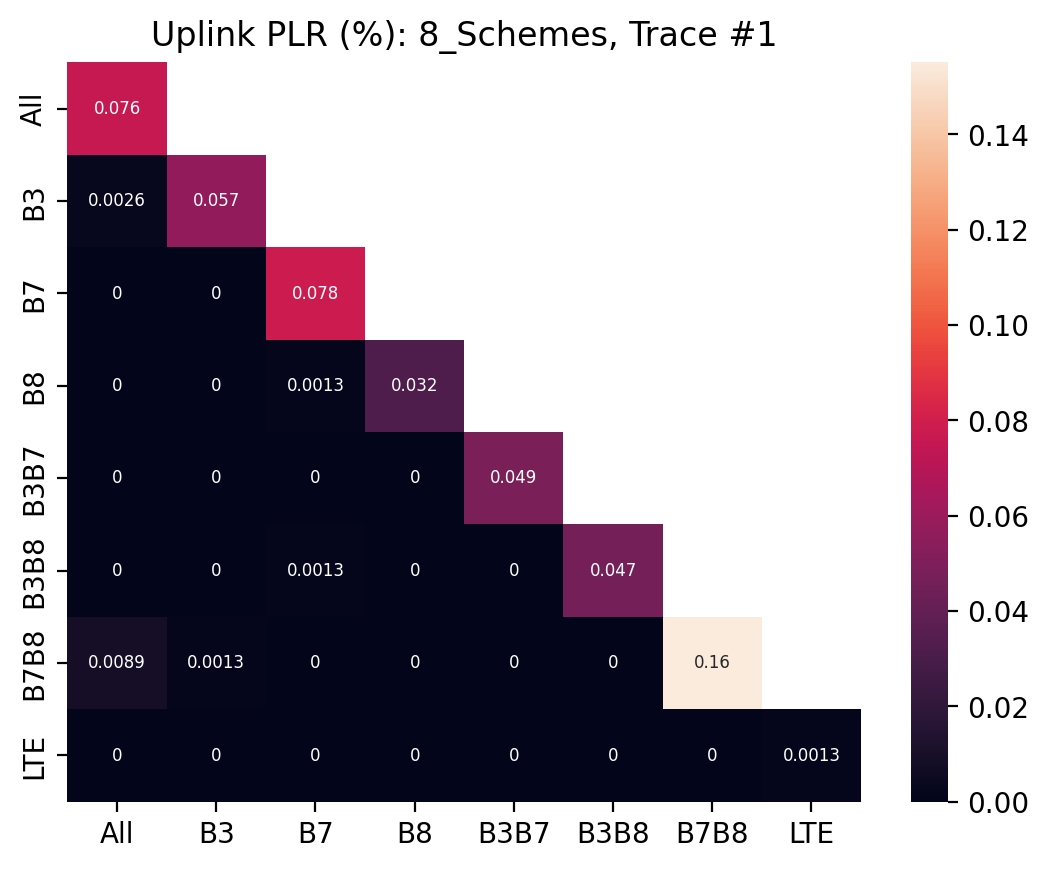

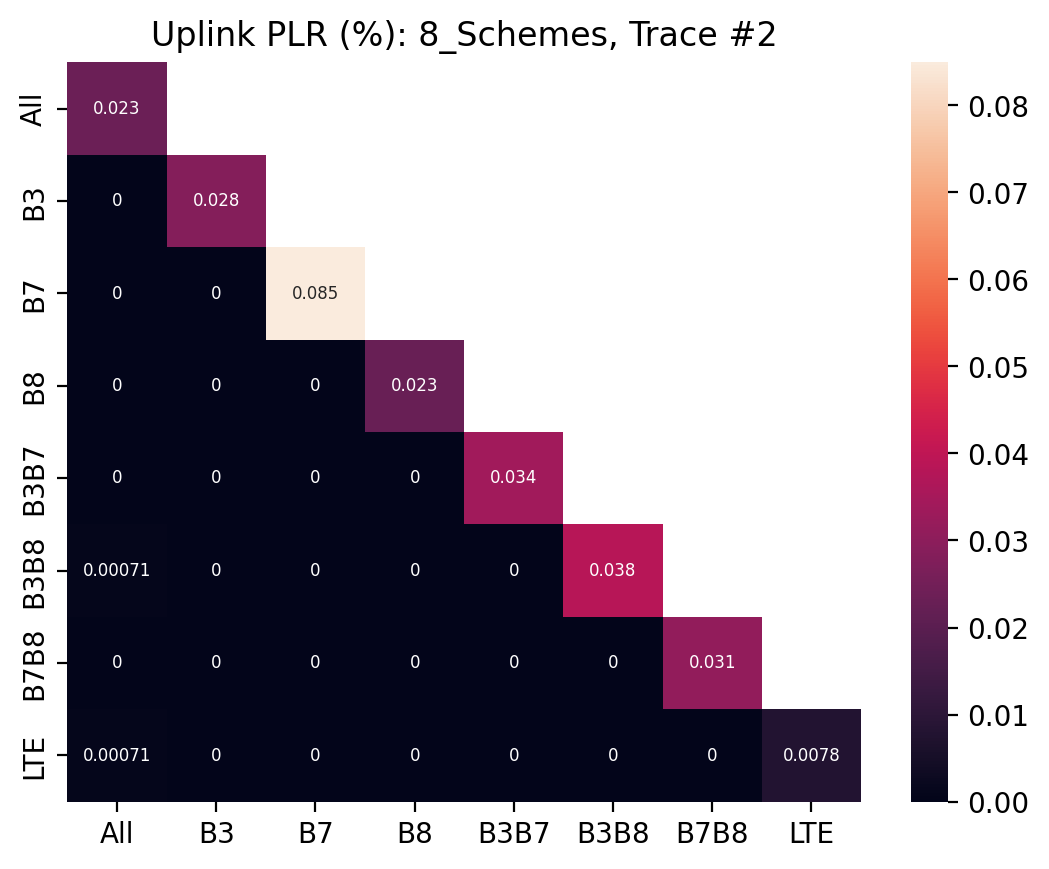

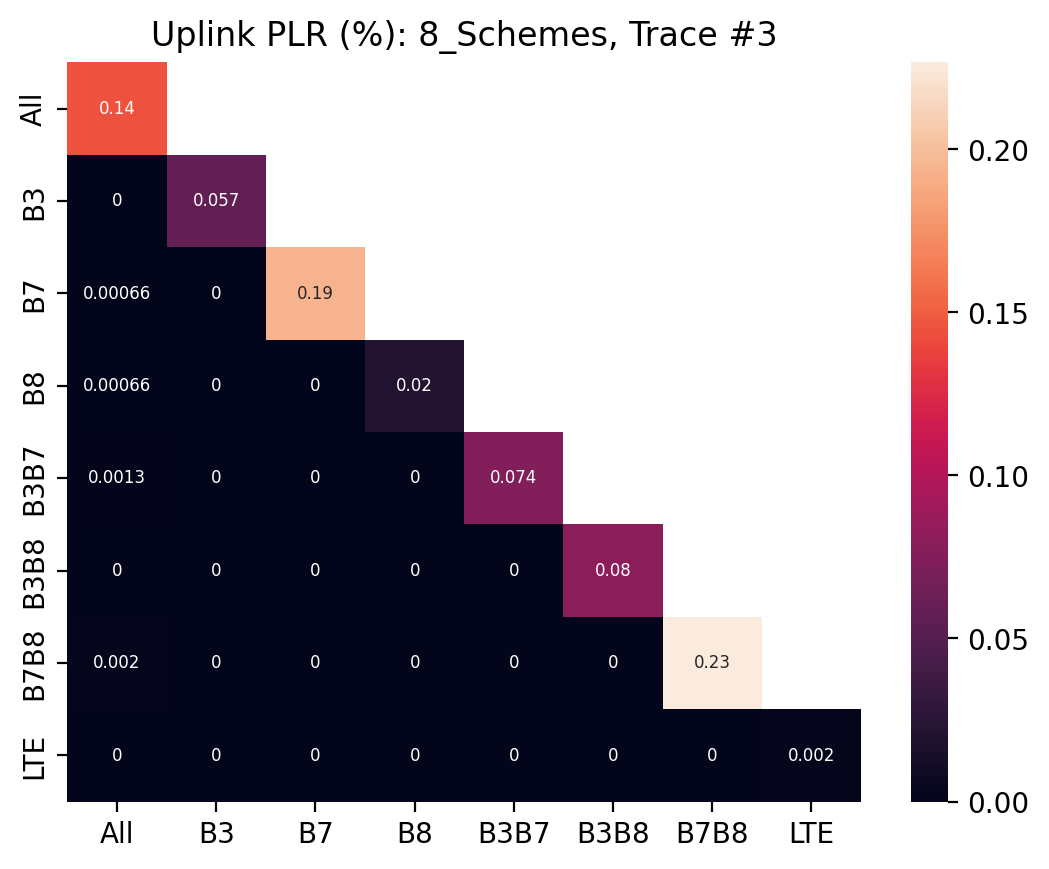

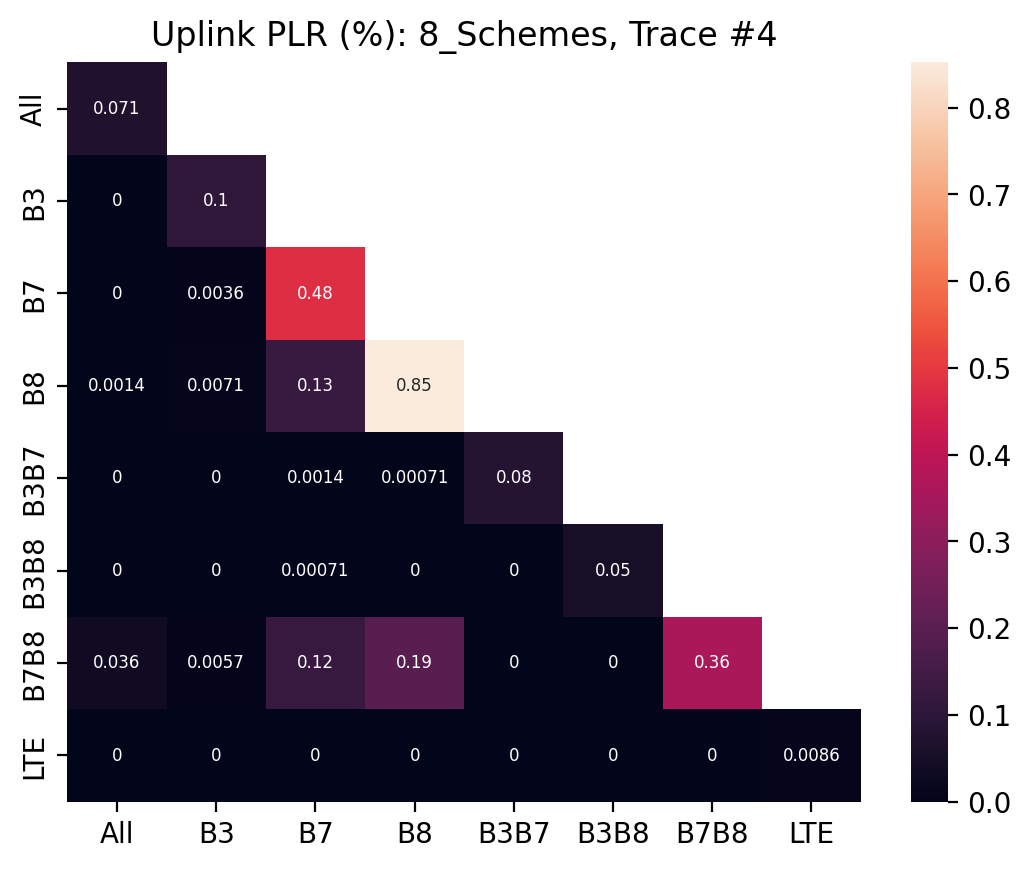

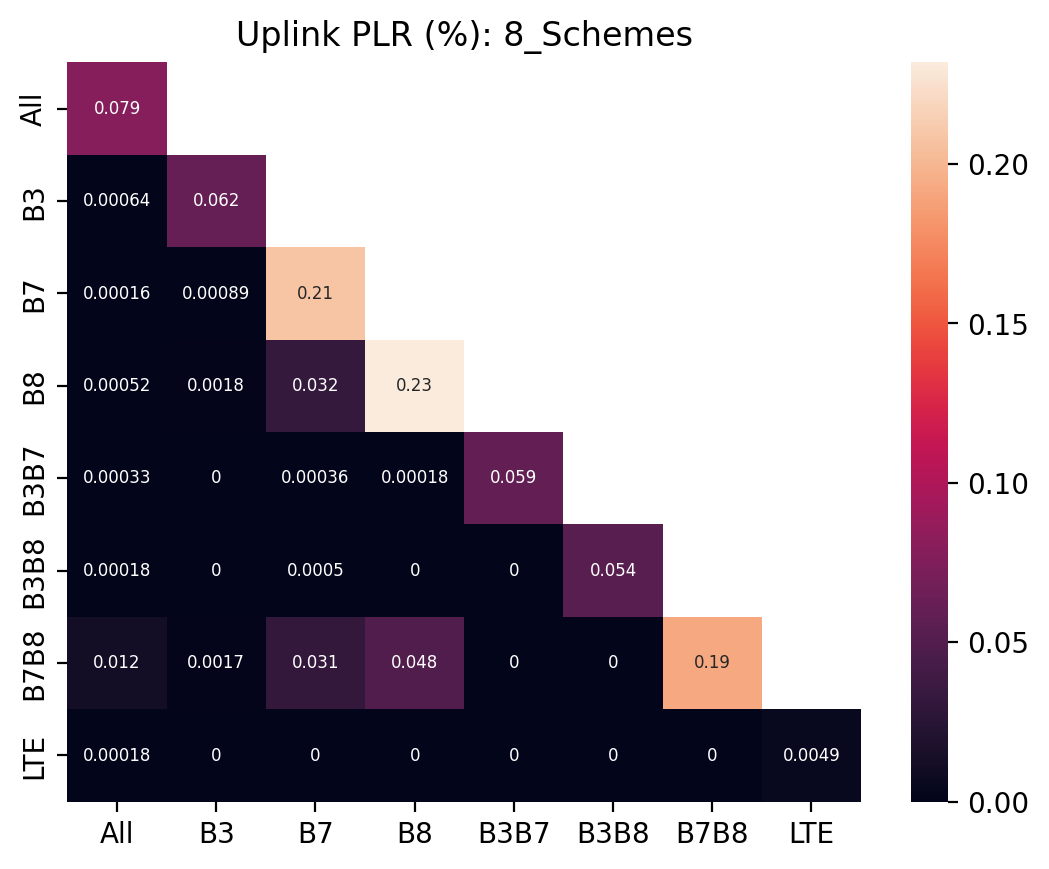

In [16]:
N = len(dfs_ul)
devices = _devices[0]

table = pd.DataFrame(columns=tags)
for i in range(N):
    row = []
    for x, tag in zip(xs, tags):
        if type(x) is not tuple:
            if not dfs_ul[i][x].empty:
                df = dfs_ul[i][x].copy()
                PLR = df.lost.mean() * 100
            else:
                PLR = np.nan
        else:
            if not (dfs_ul[i][x[0]].empty or dfs_ul[i][x[1]].empty):
                df = pd.merge(dfs_ul[i][x[0]].copy(), dfs_ul[i][x[1]].copy(), on=['seq'], suffixes=('_m','_s')).copy()
                PLR = (df.lost_m & df.lost_s).mean() * 100
            else:
                PLR = np.nan
        row.append(PLR)
    table = pd.concat([table, pd.DataFrame(row, index=table.columns).T])
    ## draw heatmap for one trace
    mat = fill_out_matrix(schemes, mtags, pd.DataFrame(row, index=table.columns).T.mean().to_dict())
    ax = sns.heatmap(mat.T, annot=True, fmt='.2g', mask=mask(len(schemes)), annot_kws={"size": 6})
    ax.set_title(f'Uplink PLR (%): {title}, Trace #{i+1}')
    plt.savefig(os.path.join(path, f'{title}_ULPLR_{i+1}.png'), bbox_inches='tight', dpi=300)
    plt.show()

mat = fill_out_matrix(schemes, mtags, table.mean().to_dict())
ax = sns.heatmap(mat.T, annot=True, fmt='.2g', mask=mask(len(schemes)), annot_kws={"size": 6})
ax.set_title(f'Uplink PLR (%): {title}')
plt.savefig(os.path.join(path, f'{title}_ULPLR.png'), bbox_inches='tight', dpi=300)
plt.show()

## Downlink PLR

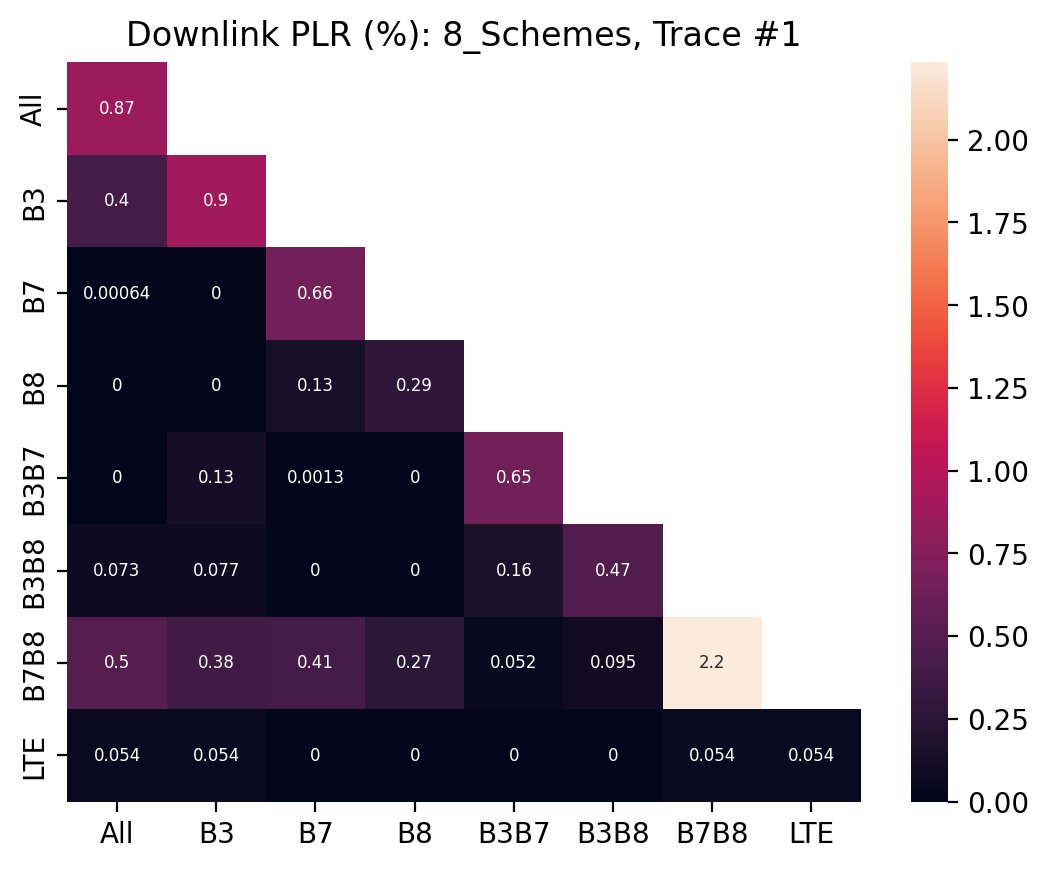

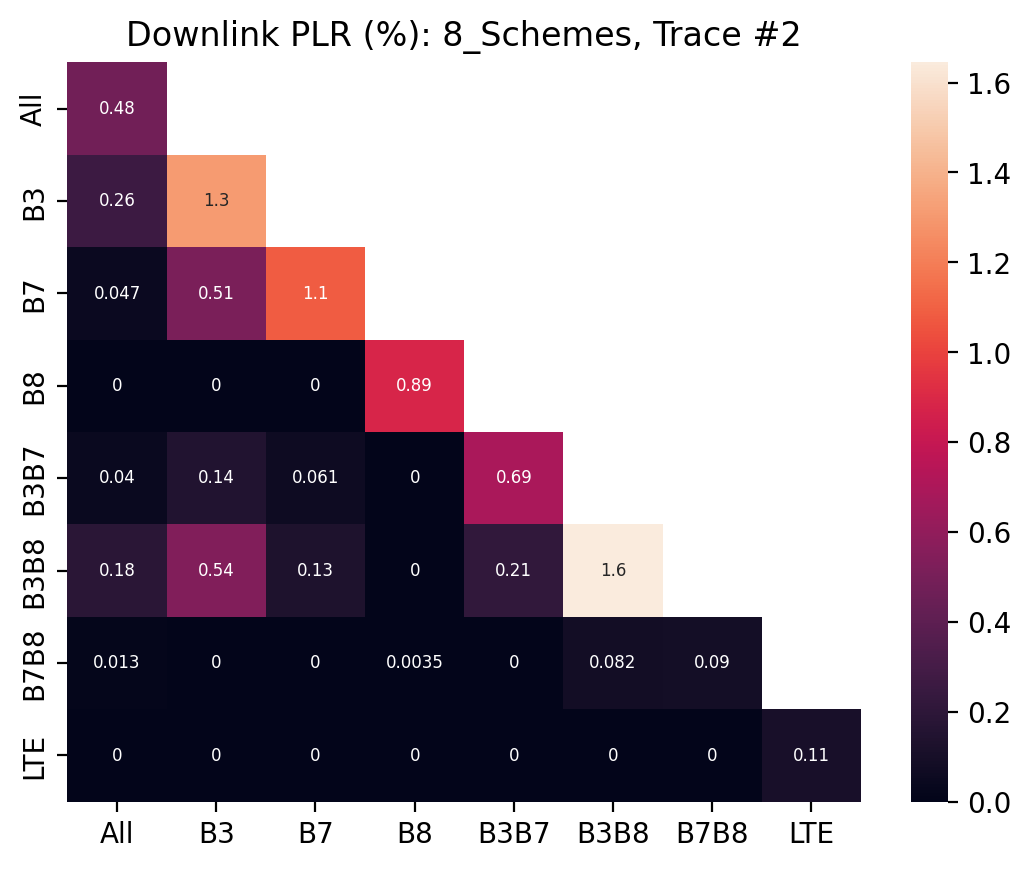

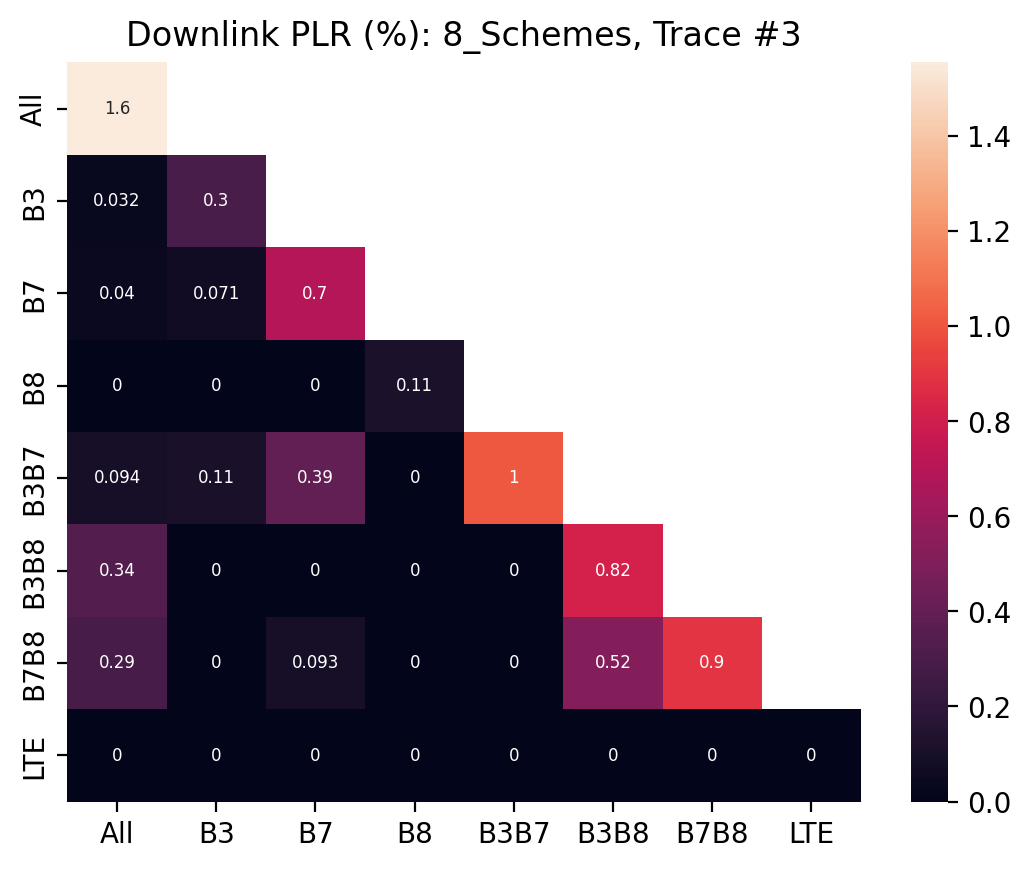

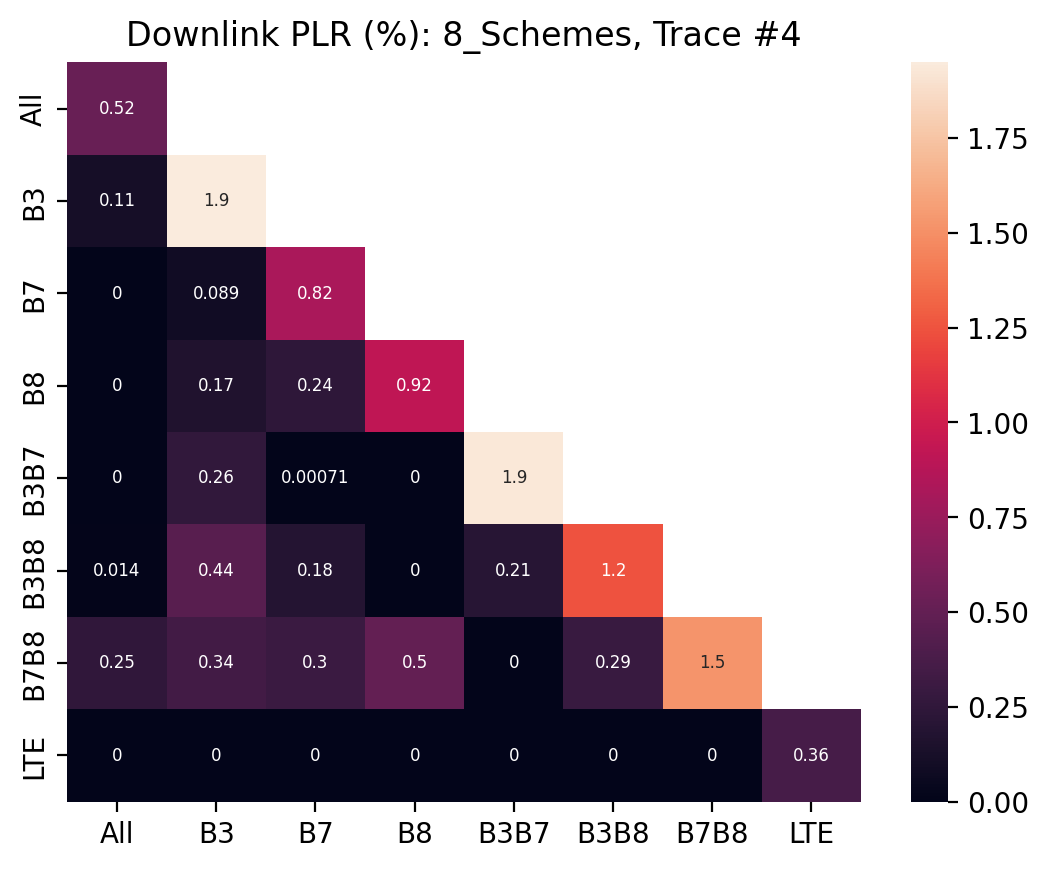

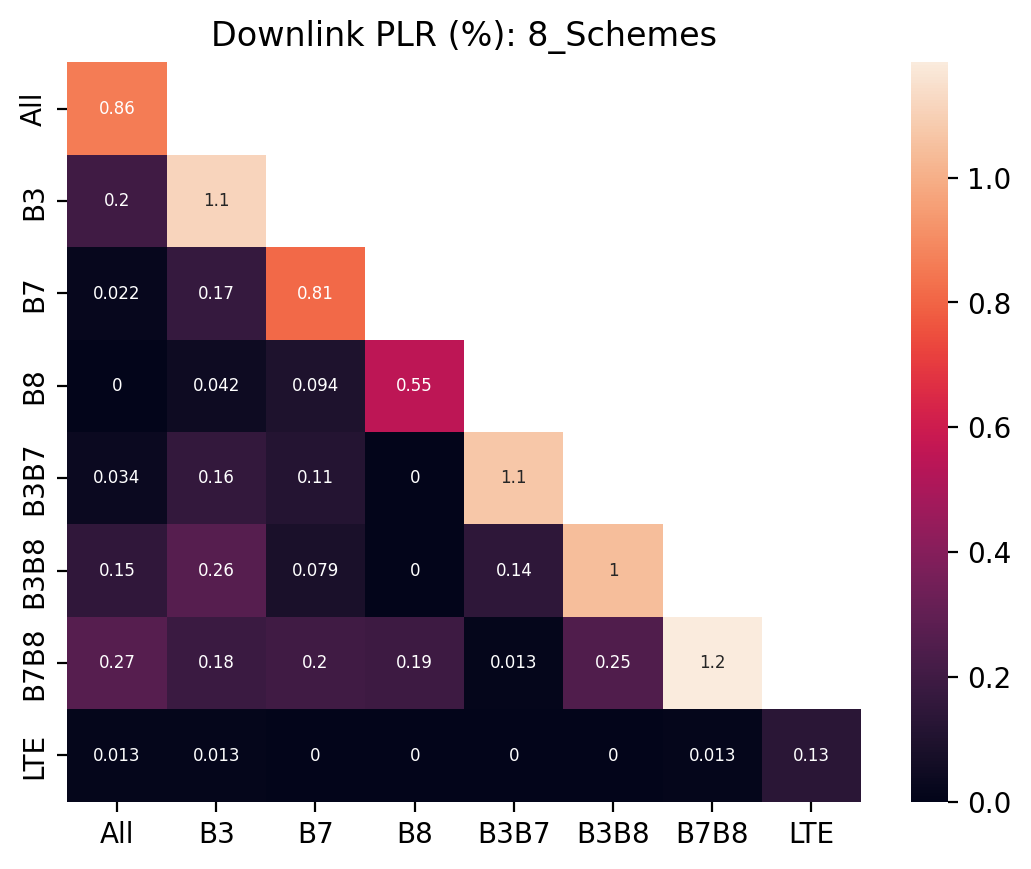

In [17]:
N = len(dfs_dl)
devices = _devices[0]

table = pd.DataFrame(columns=tags)
for i in range(N):
    row = []
    for x, tag in zip(xs, tags):
        if type(x) is not tuple:
            if not dfs_dl[i][x].empty:
                df = dfs_dl[i][x].copy()
                PLR = df.lost.mean() * 100
            else:
                PLR = np.nan
        else:
            if not (dfs_dl[i][x[0]].empty or dfs_dl[i][x[1]].empty):
                df = pd.merge(dfs_dl[i][x[0]].copy(), dfs_dl[i][x[1]].copy(), on=['seq'], suffixes=('_m','_s')).copy()
                PLR = (df.lost_m & df.lost_s).mean() * 100
            else:
                PLR = np.nan
        row.append(PLR)
    table = pd.concat([table, pd.DataFrame(row, index=table.columns).T])
    ## draw heatmap for one trace
    mat = fill_out_matrix(schemes, mtags, pd.DataFrame(row, index=table.columns).T.mean().to_dict())
    ax = sns.heatmap(mat.T, annot=True, fmt='.2g', mask=mask(len(schemes)), annot_kws={"size": 6})
    ax.set_title(f'Downlink PLR (%): {title}, Trace #{i+1}')
    plt.savefig(os.path.join(path, f'{title}_DLPLR_{i+1}.png'), bbox_inches='tight', dpi=300)
    plt.show()

mat = fill_out_matrix(schemes, mtags, table.mean().to_dict())
ax = sns.heatmap(mat.T, annot=True, fmt='.2g', mask=mask(len(schemes)), annot_kws={"size": 6})
ax.set_title(f'Downlink PLR (%): {title}')
plt.savefig(os.path.join(path, f'{title}_DLPLR.png'), bbox_inches='tight', dpi=300)
plt.show()

## Uplink ELR

4


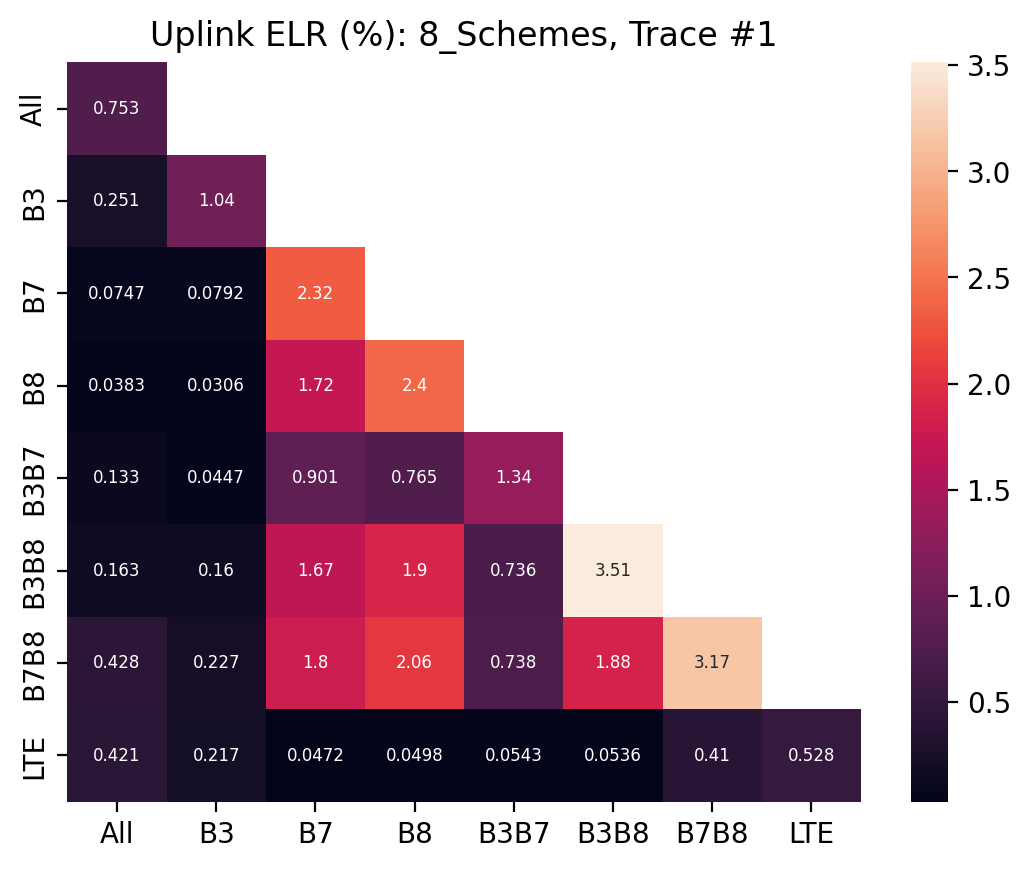

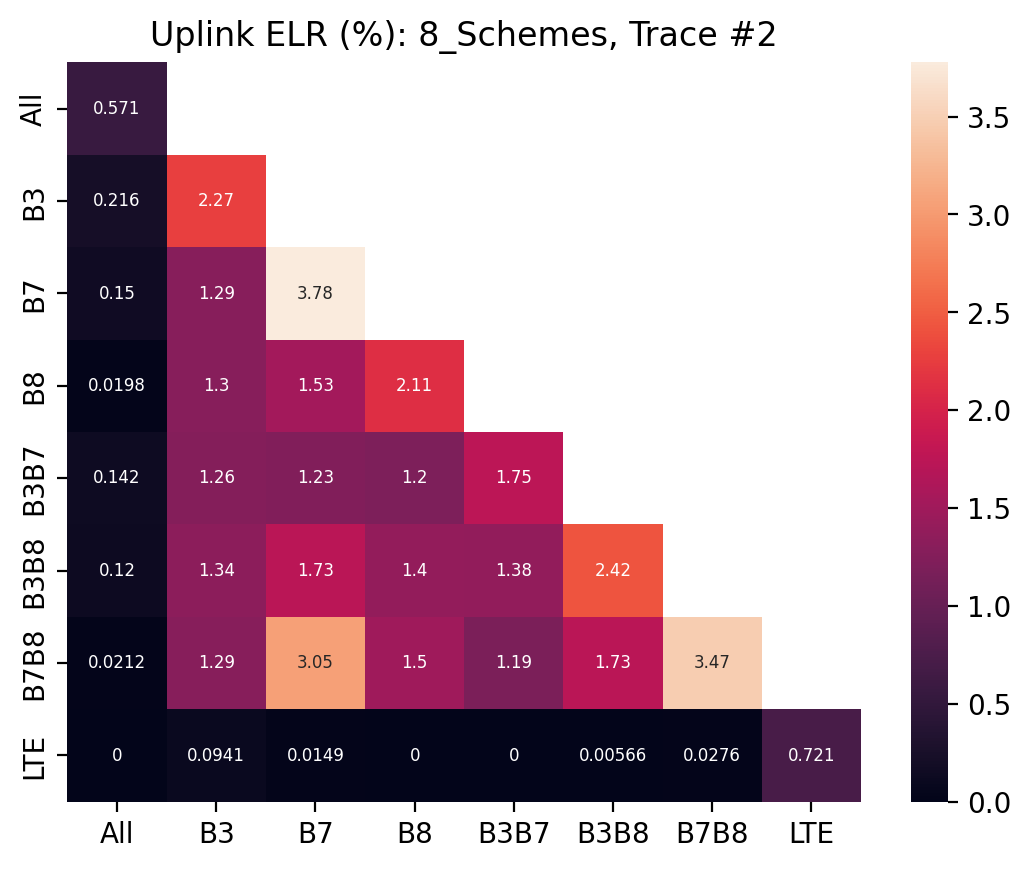

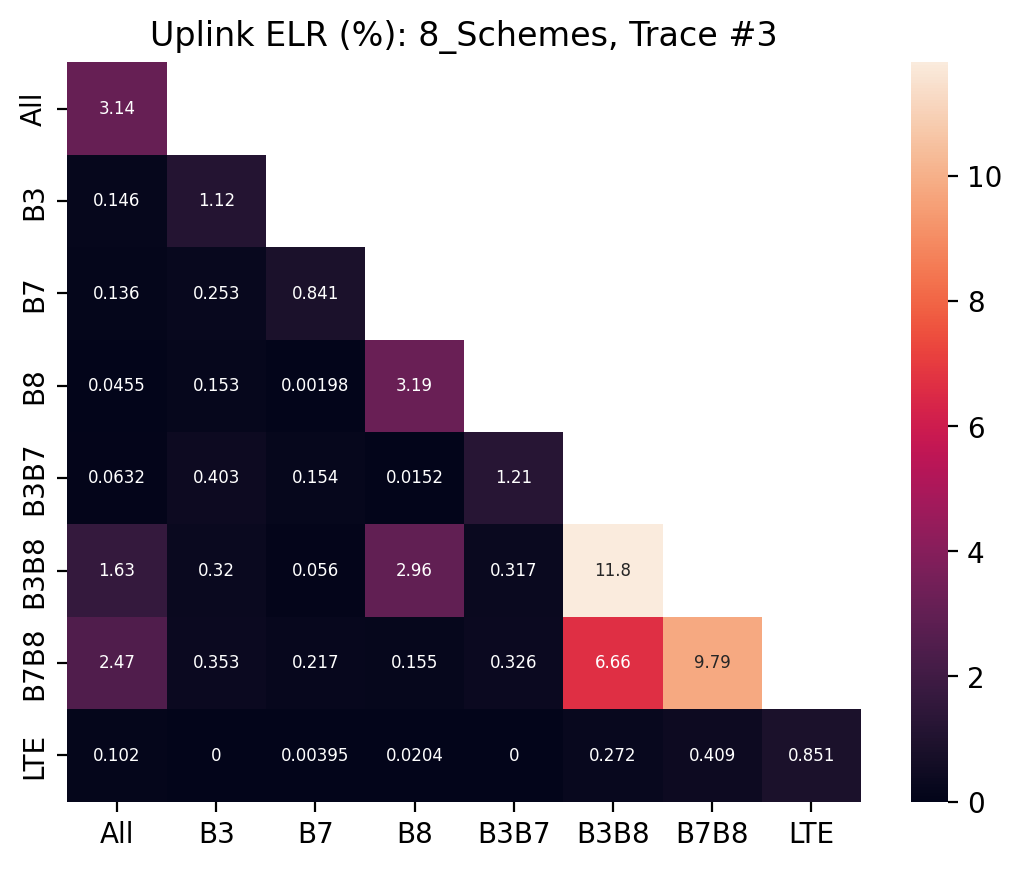

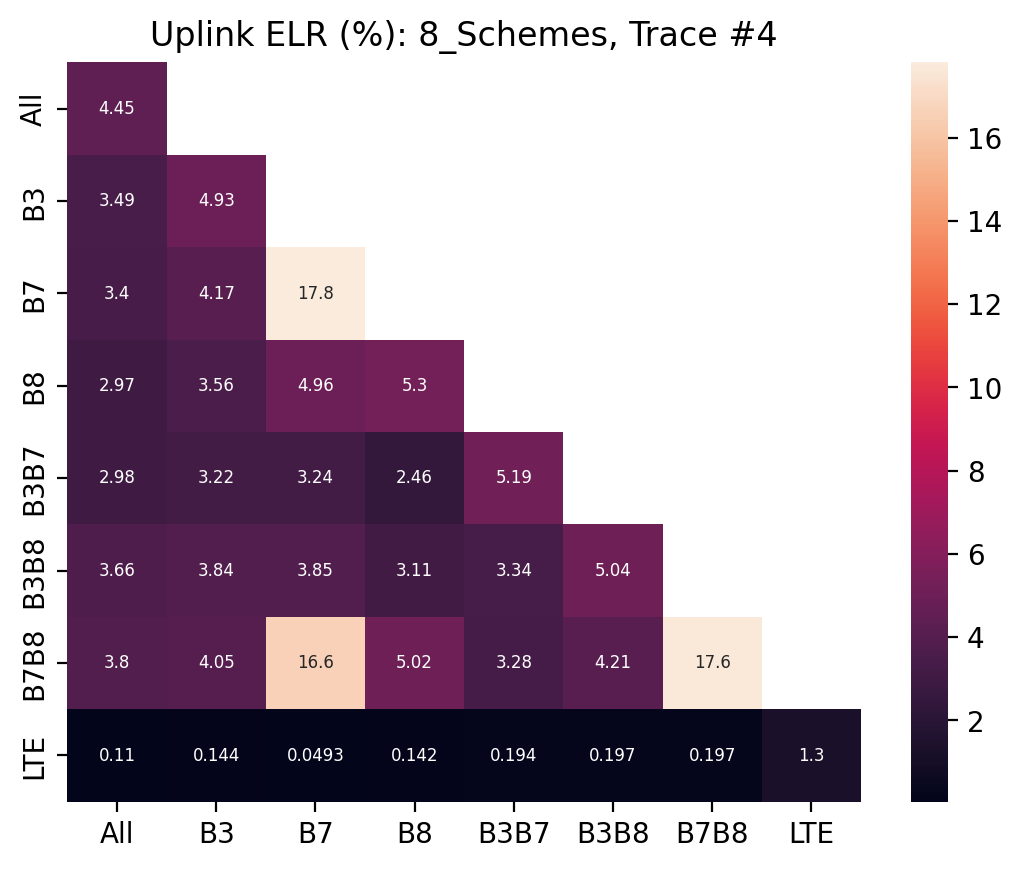

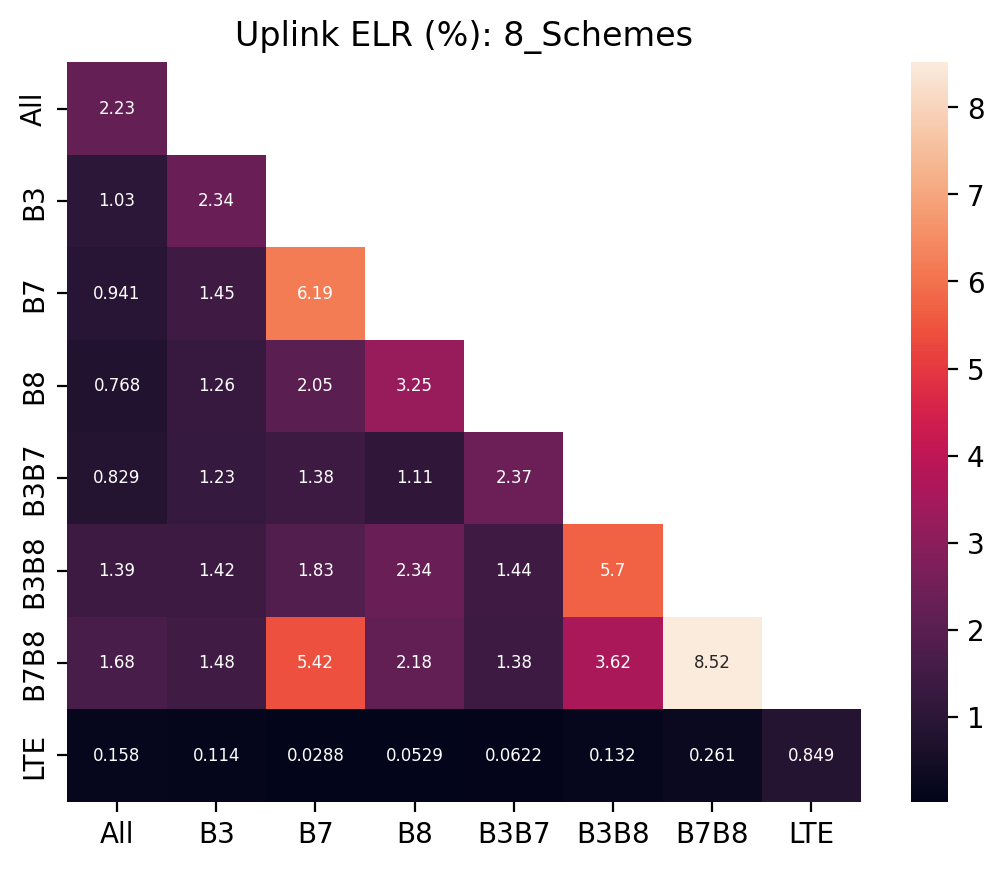

In [19]:
N = len(dfs_ul)
devices = _devices[0]

table = pd.DataFrame(columns=tags)
for i in range(N):
    row = []
    for x, tag in zip(xs, tags):
        if type(x) is not tuple:
            if not dfs_ul[i][x].empty:
                df = dfs_ul[i][x].copy()
                ELR = df[~df.lost].excl.mean() * 100
            else:
                ELR = np.nan
        else:
            if not (dfs_ul[i][x[0]].empty or dfs_ul[i][x[1]].empty):
                df = pd.merge(dfs_ul[i][x[0]].copy(), dfs_ul[i][x[1]].copy(), on=['seq'], suffixes=('_m','_s')).copy()
                ELR = (df[~(df.lost_m & df.lost_s)].excl_m & df[~(df.lost_m & df.lost_s)].excl_s).mean() * 100
            else:
                ELR = np.nan
        row.append(ELR)
    table = pd.concat([table, pd.DataFrame(row, index=table.columns).T])
    ## draw heatmap for one trace
    mat = fill_out_matrix(schemes, mtags, pd.DataFrame(row, index=table.columns).T.mean().to_dict())
    ax = sns.heatmap(mat.T, annot=True, fmt='.3g', mask=mask(len(schemes)), annot_kws={"size": 6})
    ax.set_title(f'Uplink ELR (%): {title}, Trace #{i+1}')
    plt.savefig(os.path.join(path, f'{title}_ULELR_{i+1}.png'), bbox_inches='tight', dpi=300)
    plt.show()

mat = fill_out_matrix(schemes, mtags, table.mean().to_dict())
ax = sns.heatmap(mat.T, annot=True, fmt='.3g', mask=mask(len(schemes)), annot_kws={"size": 6})
ax.set_title(f'Uplink ELR (%): {title}')
plt.savefig(os.path.join(path, f'{title}_ULELR.png'), bbox_inches='tight', dpi=300)
plt.show()

## Downlink ELR

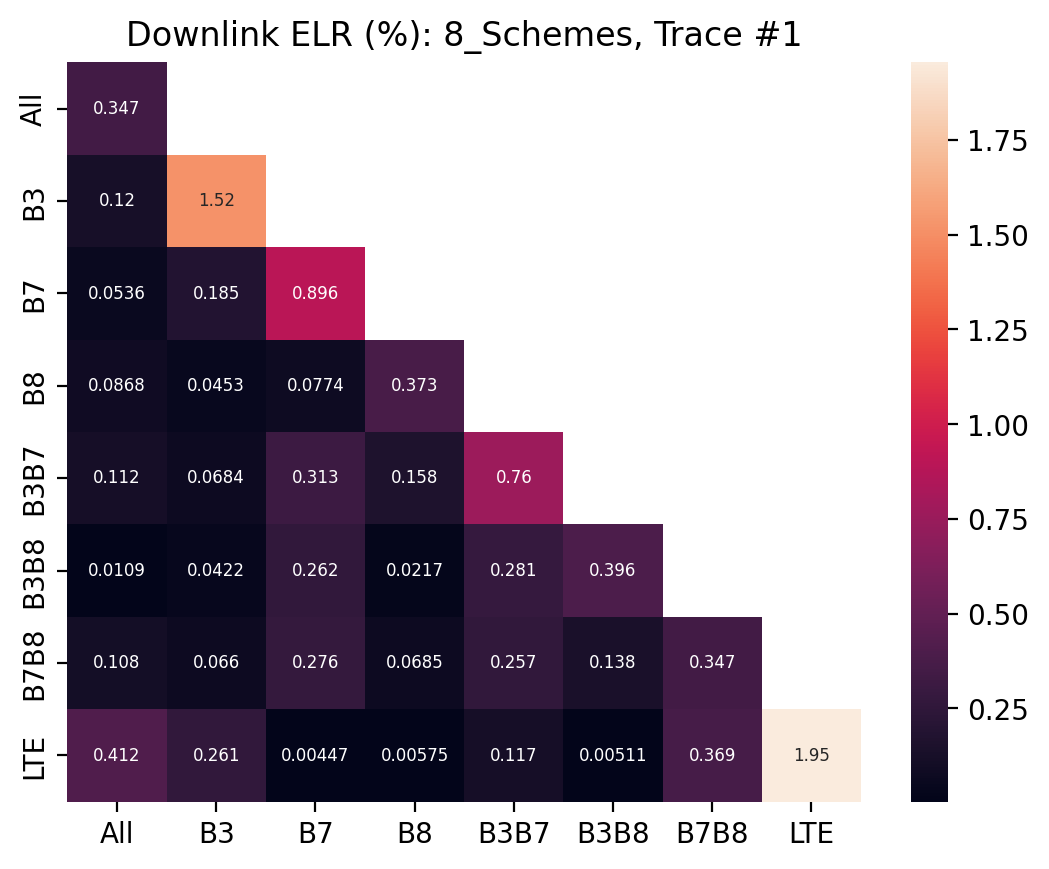

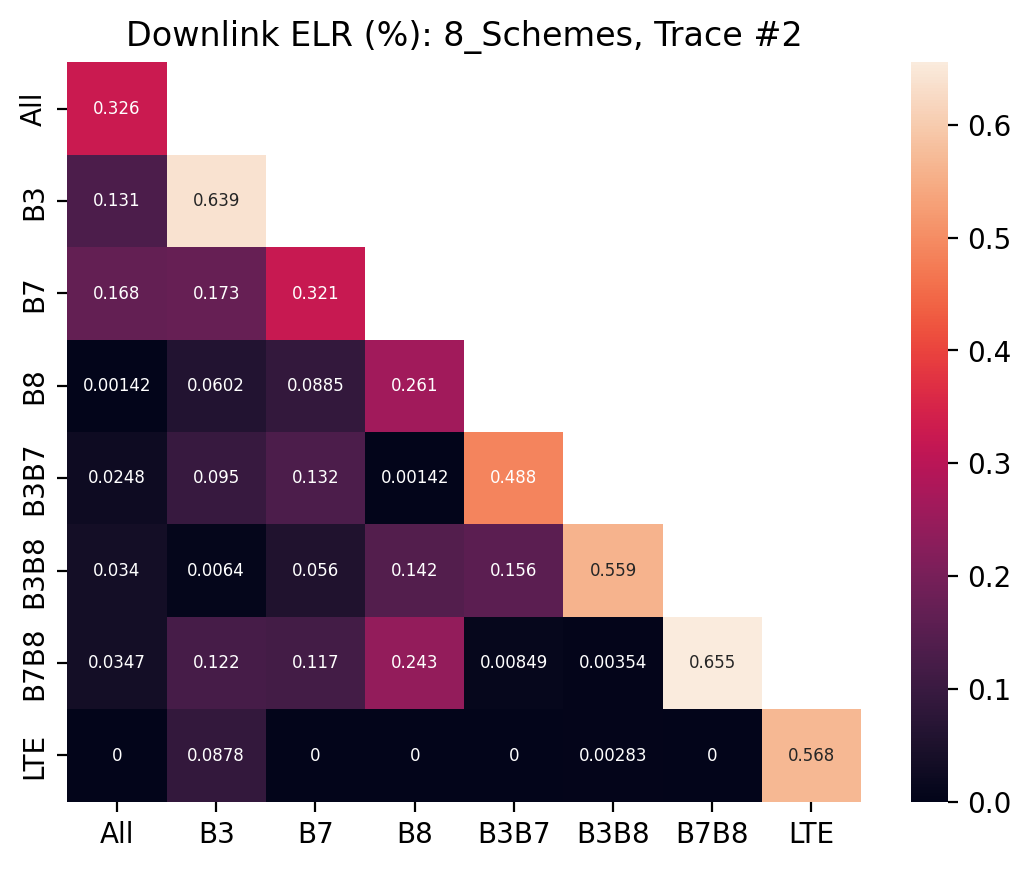

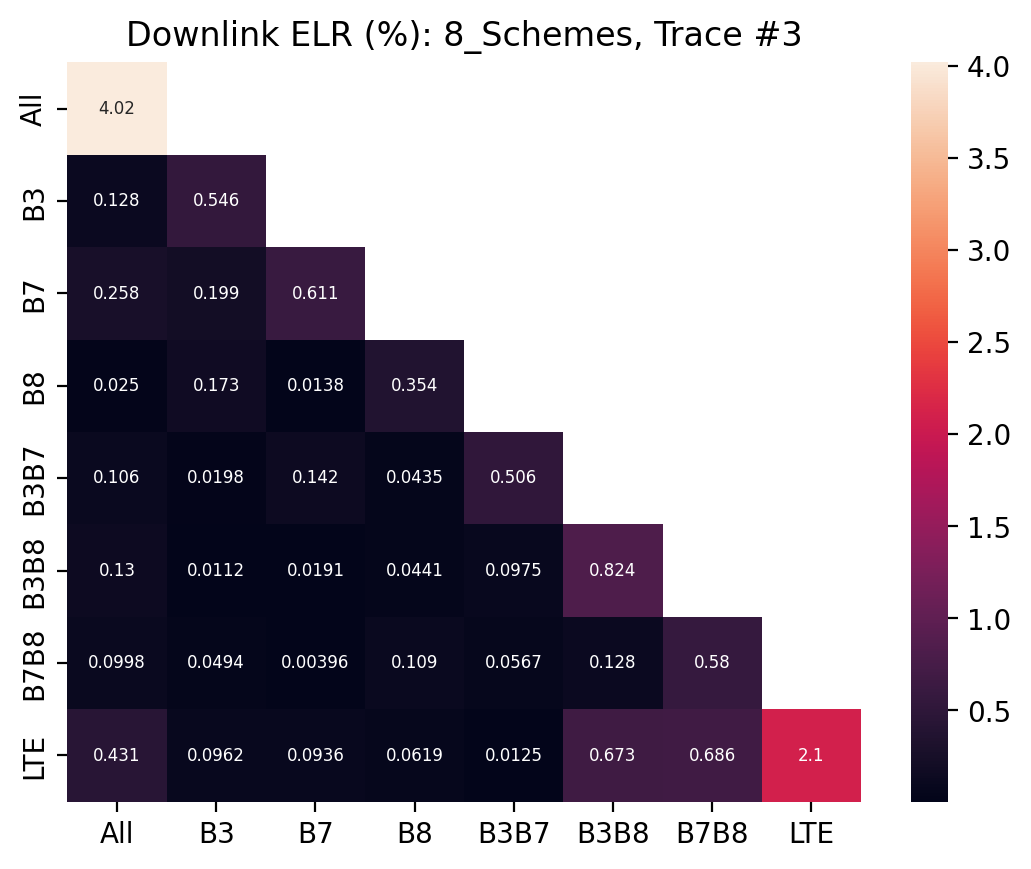

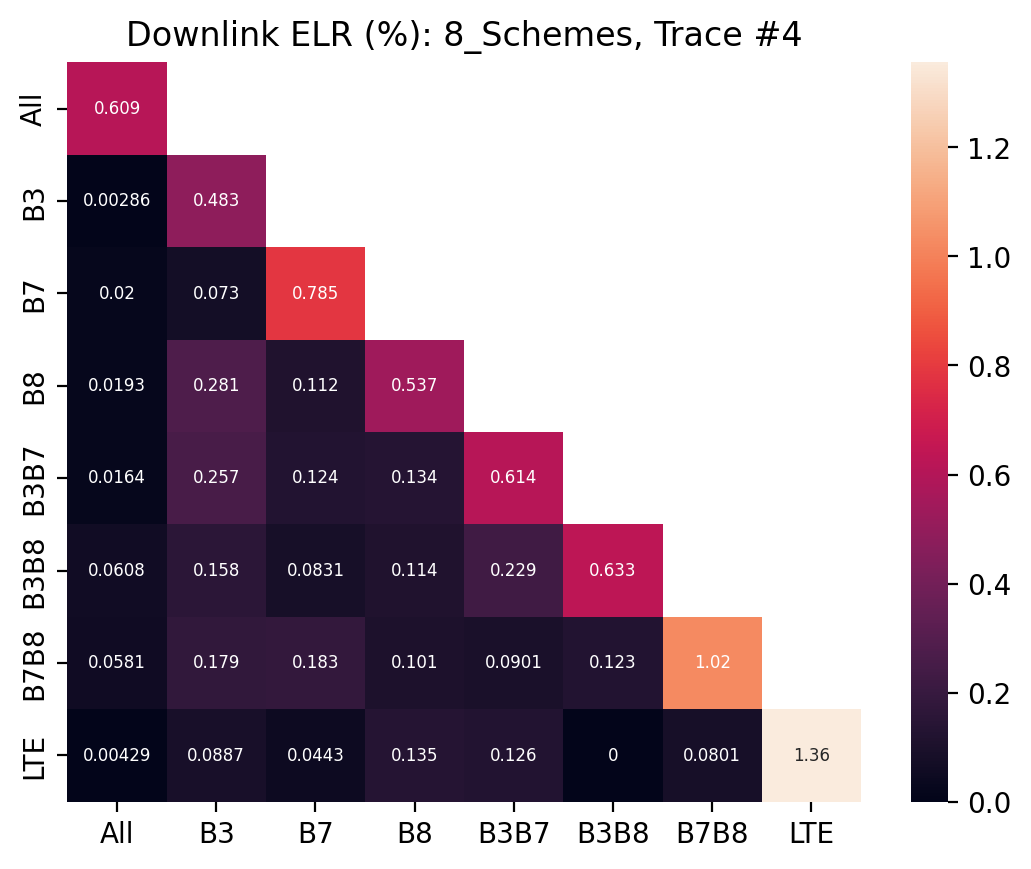

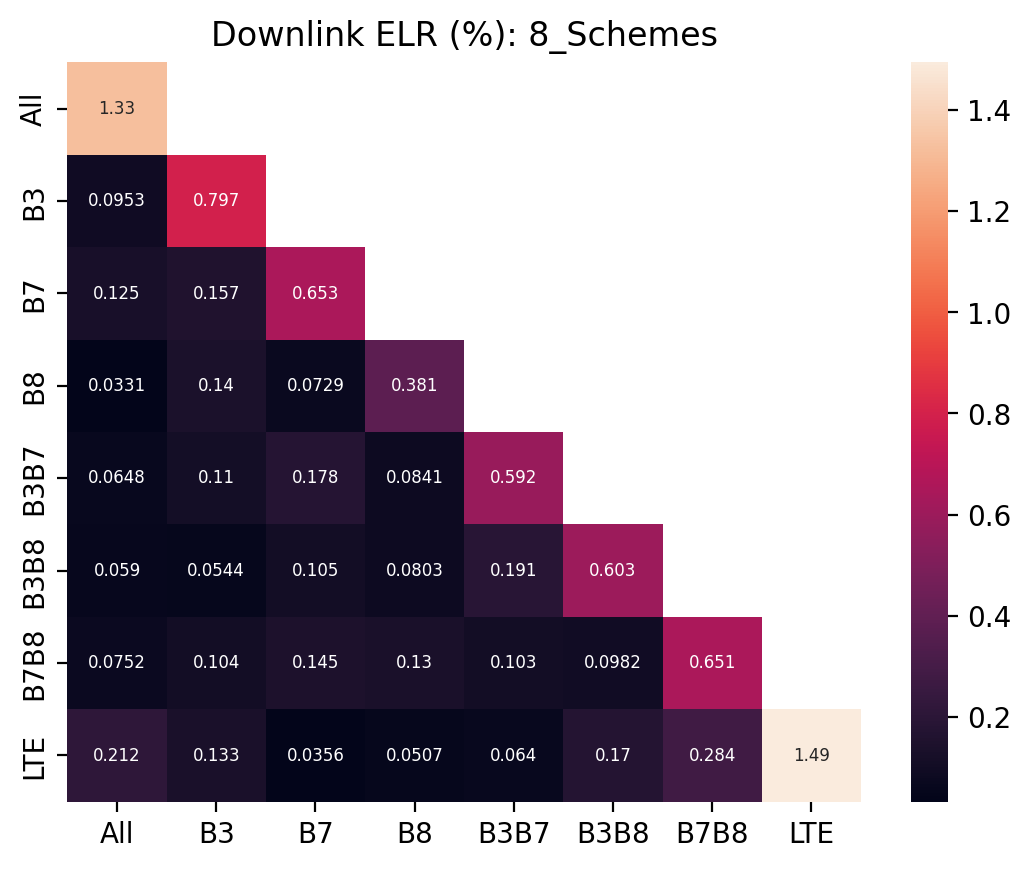

In [20]:
N = len(dfs_dl)
devices = _devices[0]

table = pd.DataFrame(columns=tags)
for i in range(N):
    row = []
    for x, tag in zip(xs, tags):
        if type(x) is not tuple:
            if not dfs_dl[i][x].empty:
                df = dfs_dl[i][x].copy()
                ELR = df[~df.lost].excl.mean() * 100
            else:
                ELR = np.nan
        else:
            if not (dfs_dl[i][x[0]].empty or dfs_dl[i][x[1]].empty):
                df = pd.merge(dfs_dl[i][x[0]].copy(), dfs_dl[i][x[1]].copy(), on=['seq'], suffixes=('_m','_s')).copy()
                ELR = (df[~(df.lost_m & df.lost_s)].excl_m & df[~(df.lost_m & df.lost_s)].excl_s).mean() * 100
            else:
                ELR = np.nan
        row.append(ELR)
    table = pd.concat([table, pd.DataFrame(row, index=table.columns).T])
    ## draw heatmap for one trace
    mat = fill_out_matrix(schemes, mtags, pd.DataFrame(row, index=table.columns).T.mean().to_dict())
    ax = sns.heatmap(mat.T, annot=True, fmt='.3g', mask=mask(len(schemes)), annot_kws={"size": 6})
    ax.set_title(f'Downlink ELR (%): {title}, Trace #{i+1}')
    plt.savefig(os.path.join(path, f'{title}_DLELR_{i+1}.png'), bbox_inches='tight', dpi=300)
    plt.show()

mat = fill_out_matrix(schemes, mtags, table.mean().to_dict())
ax = sns.heatmap(mat.T, annot=True, fmt='.3g', mask=mask(len(schemes)), annot_kws={"size": 6})
ax.set_title(f'Downlink ELR (%): {title}')
plt.savefig(os.path.join(path, f'{title}_DLELR.png'), bbox_inches='tight', dpi=300)
plt.show()

## Uplink Latency (except for lost & excl)

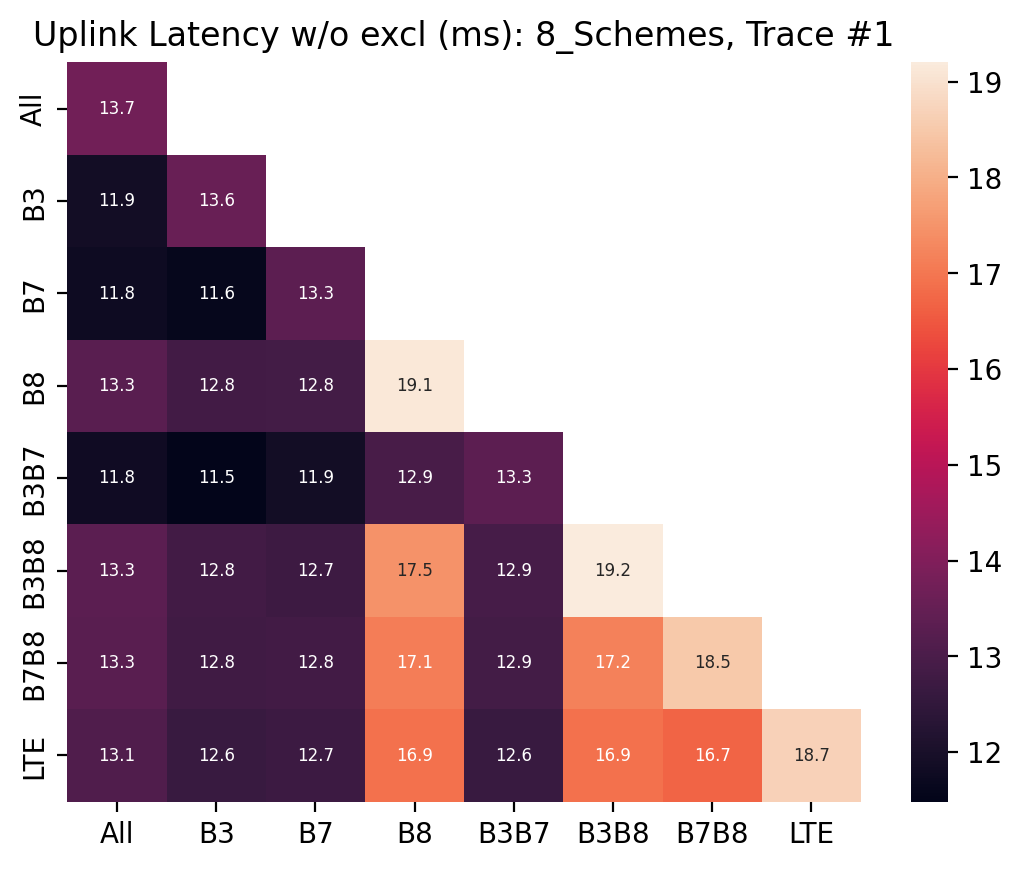

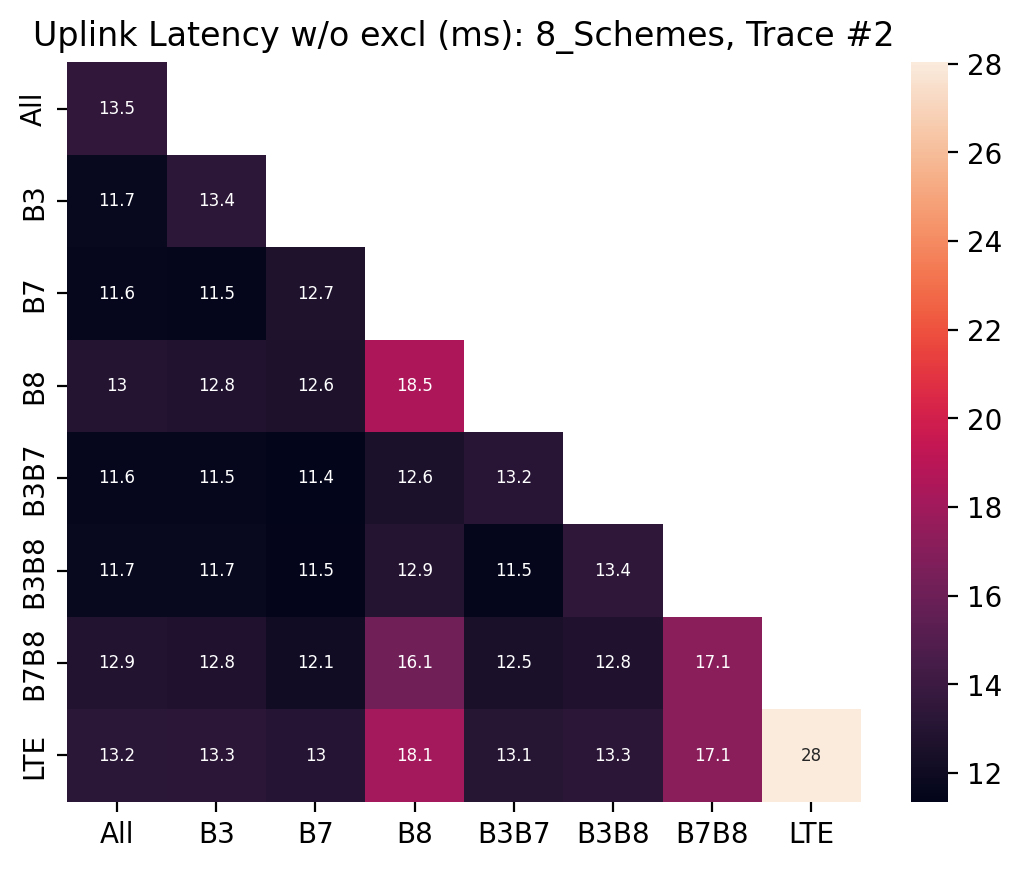

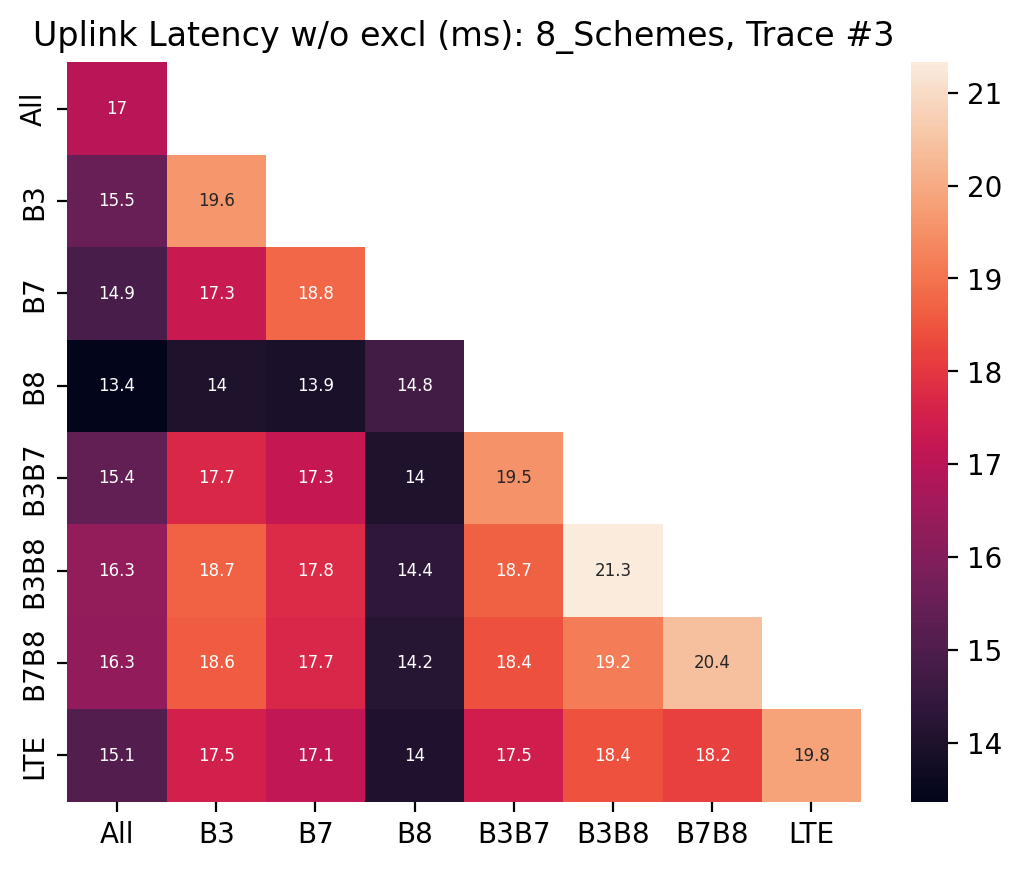

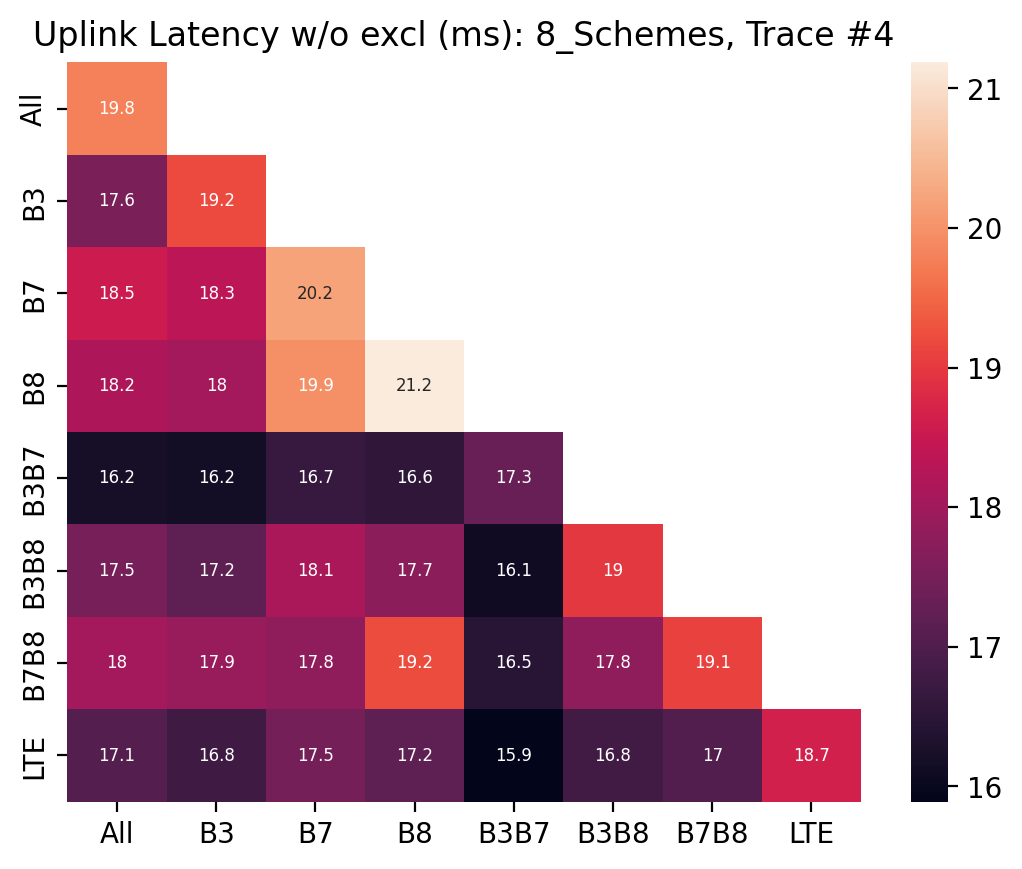

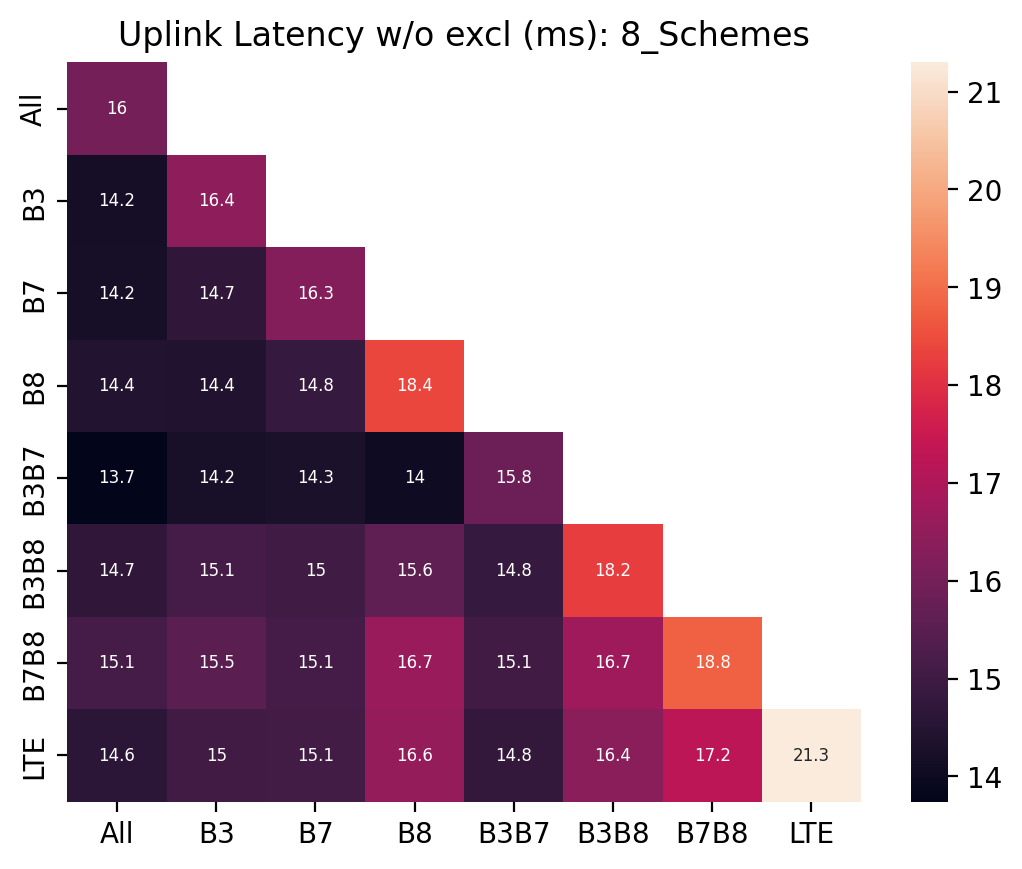

In [34]:
N = len(dfs_ul)
devices = _devices[0]

table = pd.DataFrame(columns=tags)
for i in range(N):
    row = []
    for x, tag in zip(xs, tags):
        if type(x) is not tuple:
            if not dfs_ul[i][x].empty:
                df = dfs_ul[i][x].copy()
                latency = df[~df.excl].latency.mean() * 1000
            else:
                latency = np.nan
        else:
            if not (dfs_ul[i][x[0]].empty or dfs_ul[i][x[1]].empty):
                df = pd.merge(dfs_ul[i][x[0]].copy(), dfs_ul[i][x[1]].copy(), on=['seq'], suffixes=('_m','_s')).copy()
                latency = df.loc[~(df.excl_m & df.excl_s), ['latency_m','latency_s']].min(axis=1).mean() * 1000
            else:
                latency = np.nan
        row.append(latency)
    table = pd.concat([table, pd.DataFrame(row, index=table.columns).T])
    ## draw heatmap for one trace
    mat = fill_out_matrix(schemes, mtags, pd.DataFrame(row, index=table.columns).T.mean().to_dict())
    ax = sns.heatmap(mat.T, annot=True, fmt='.3g', mask=mask(len(schemes)), annot_kws={"size": 6})
    ax.set_title(f'Uplink Latency w/o excl (ms): {title}, Trace #{i+1}')
    plt.savefig(os.path.join(path, f'{title}_ULLat1_{i+1}.png'), bbox_inches='tight', dpi=300)
    plt.show()

mat = fill_out_matrix(schemes, mtags, table.mean().to_dict())
ax = sns.heatmap(mat.T, annot=True, fmt='.3g', mask=mask(len(schemes)), annot_kws={"size": 6})
ax.set_title(f'Uplink Latency w/o excl (ms): {title}')
plt.savefig(os.path.join(path, f'{title}_ULLat1.png'), bbox_inches='tight', dpi=300)
plt.show()

## Downlink Latency (except for lost & excl)

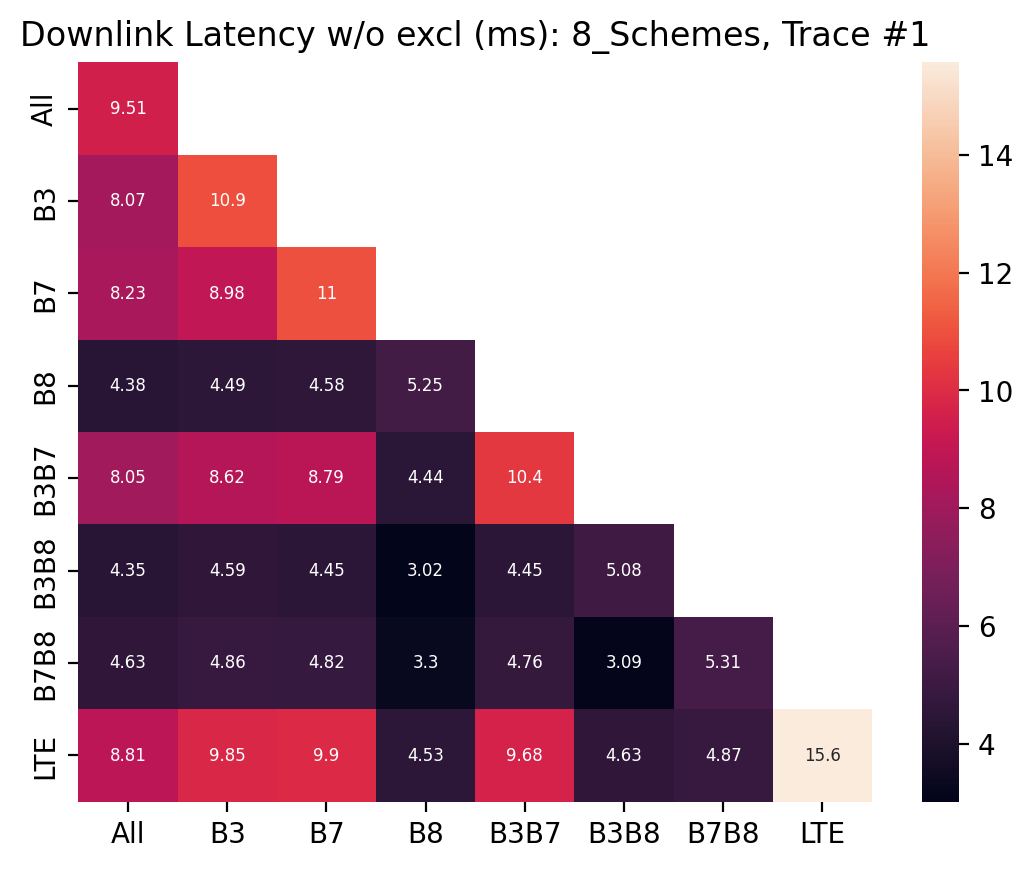

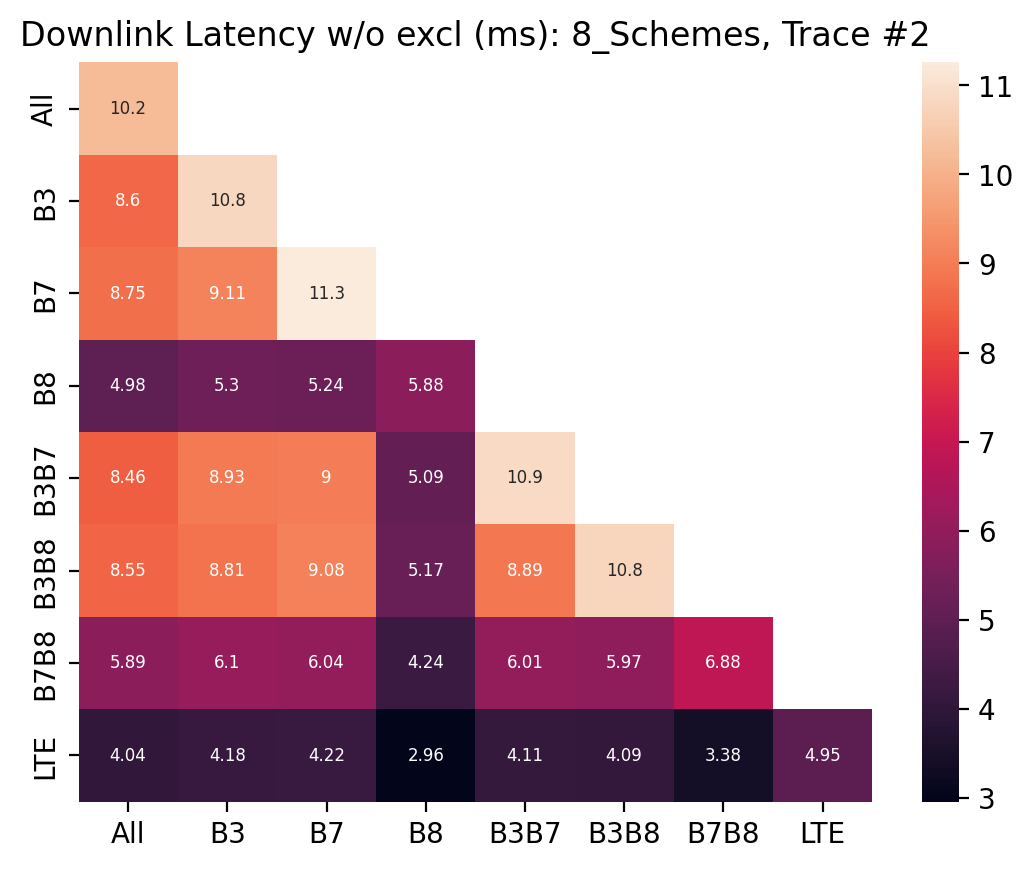

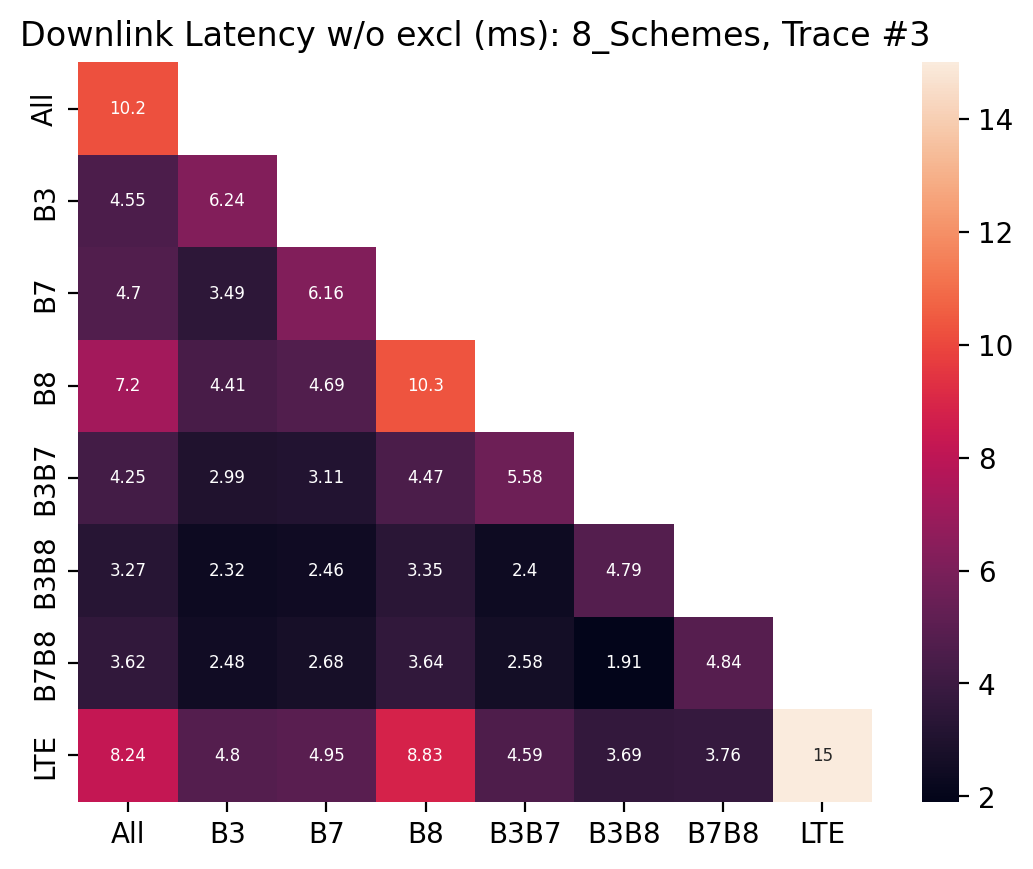

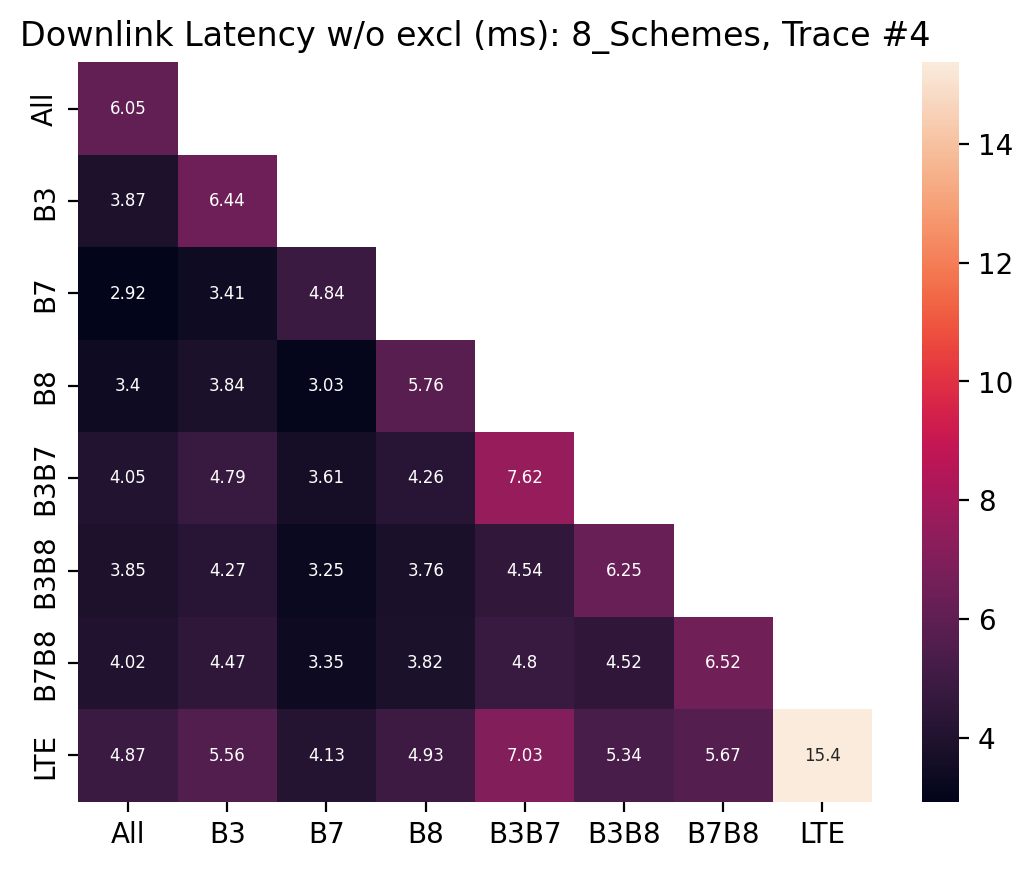

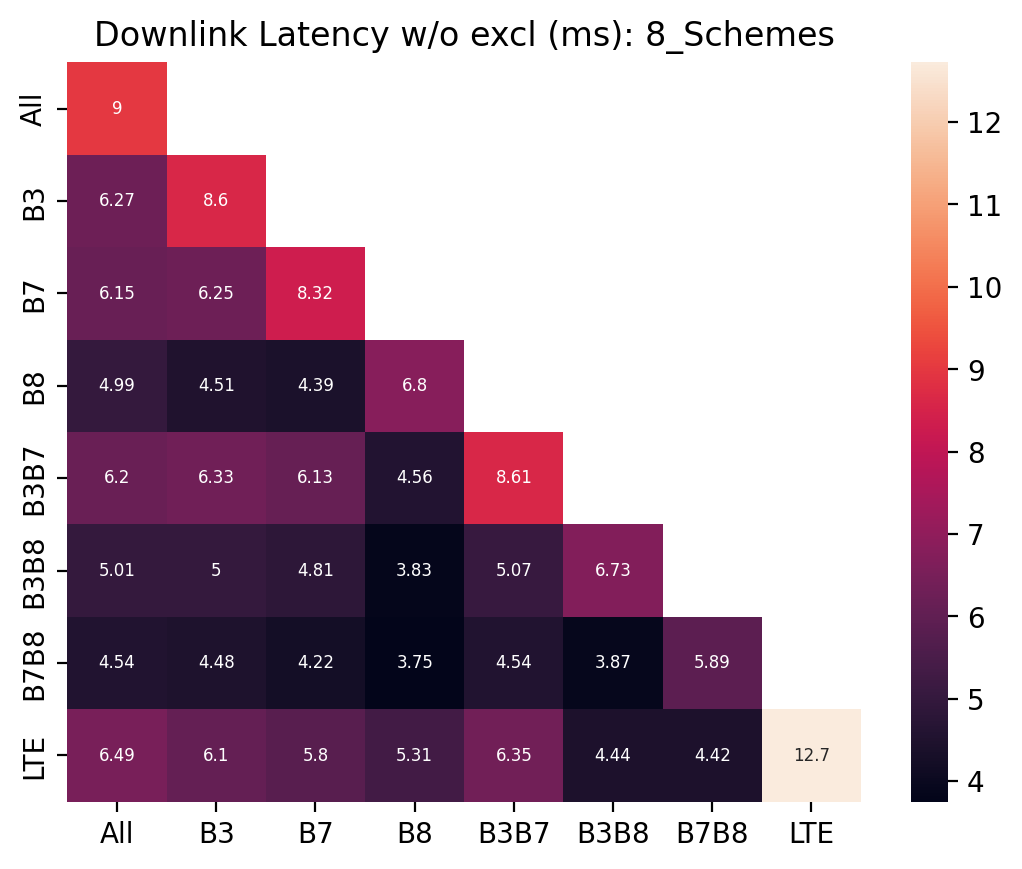

In [35]:
N = len(dfs_dl)
devices = _devices[0]

table = pd.DataFrame(columns=tags)
for i in range(N):
    row = []
    for x, tag in zip(xs, tags):
        if type(x) is not tuple:
            if not dfs_dl[i][x].empty:
                df = dfs_dl[i][x].copy()
                latency = df[~df.excl].latency.mean() * 1000
            else:
                latency = np.nan
        else:
            if not (dfs_dl[i][x[0]].empty or dfs_dl[i][x[1]].empty):
                df = pd.merge(dfs_dl[i][x[0]].copy(), dfs_dl[i][x[1]].copy(), on=['seq'], suffixes=('_m','_s')).copy()
                latency = df.loc[~(df.excl_m & df.excl_s), ['latency_m','latency_s']].min(axis=1).mean() * 1000
            else:
                latency = np.nan
        row.append(latency)
    table = pd.concat([table, pd.DataFrame(row, index=table.columns).T])
    ## draw heatmap for one trace
    mat = fill_out_matrix(schemes, mtags, pd.DataFrame(row, index=table.columns).T.mean().to_dict())
    ax = sns.heatmap(mat.T, annot=True, fmt='.3g', mask=mask(len(schemes)), annot_kws={"size": 6})
    ax.set_title(f'Downlink Latency w/o excl (ms): {title}, Trace #{i+1}')
    plt.savefig(os.path.join(path, f'{title}_DLLat1_{i+1}.png'), bbox_inches='tight', dpi=300)
    plt.show()

mat = fill_out_matrix(schemes, mtags, table.mean().to_dict())
ax = sns.heatmap(mat.T, annot=True, fmt='.3g', mask=mask(len(schemes)), annot_kws={"size": 6})
ax.set_title(f'Downlink Latency w/o excl (ms): {title}')
plt.savefig(os.path.join(path, f'{title}_DLLat1.png'), bbox_inches='tight', dpi=300)
plt.show()

## Uplink Latency (except for lost)

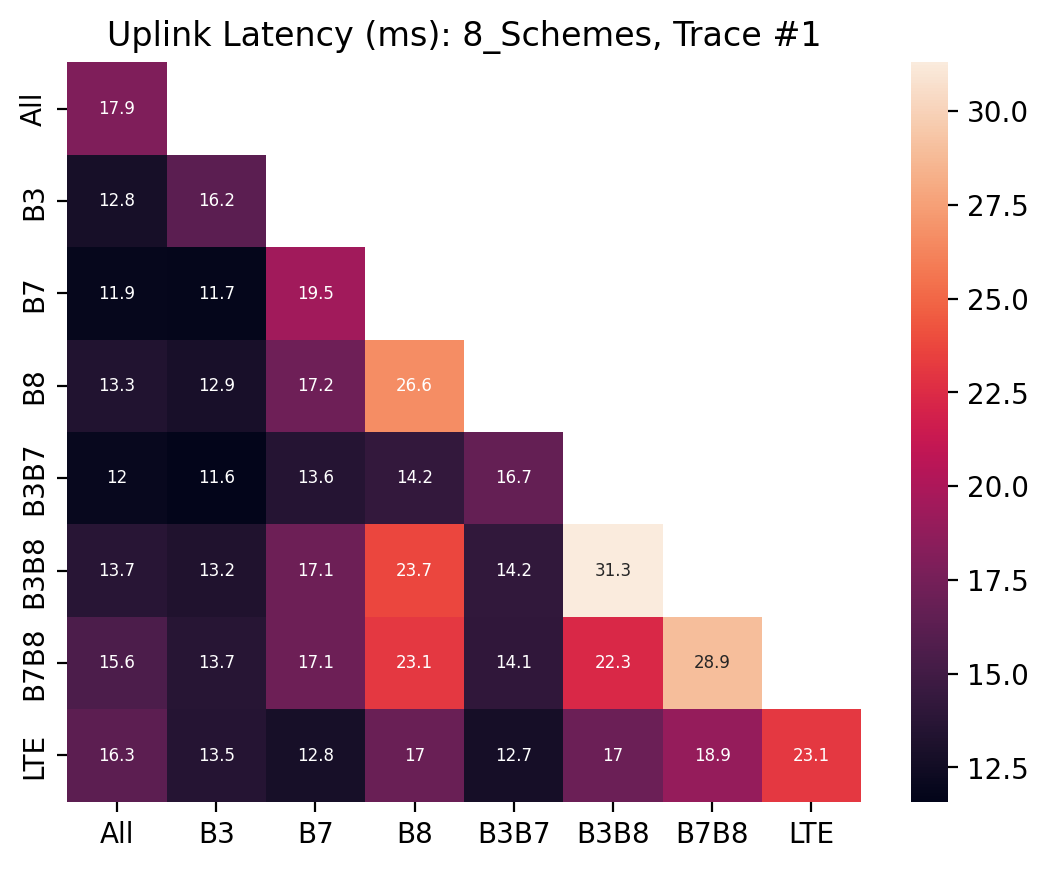

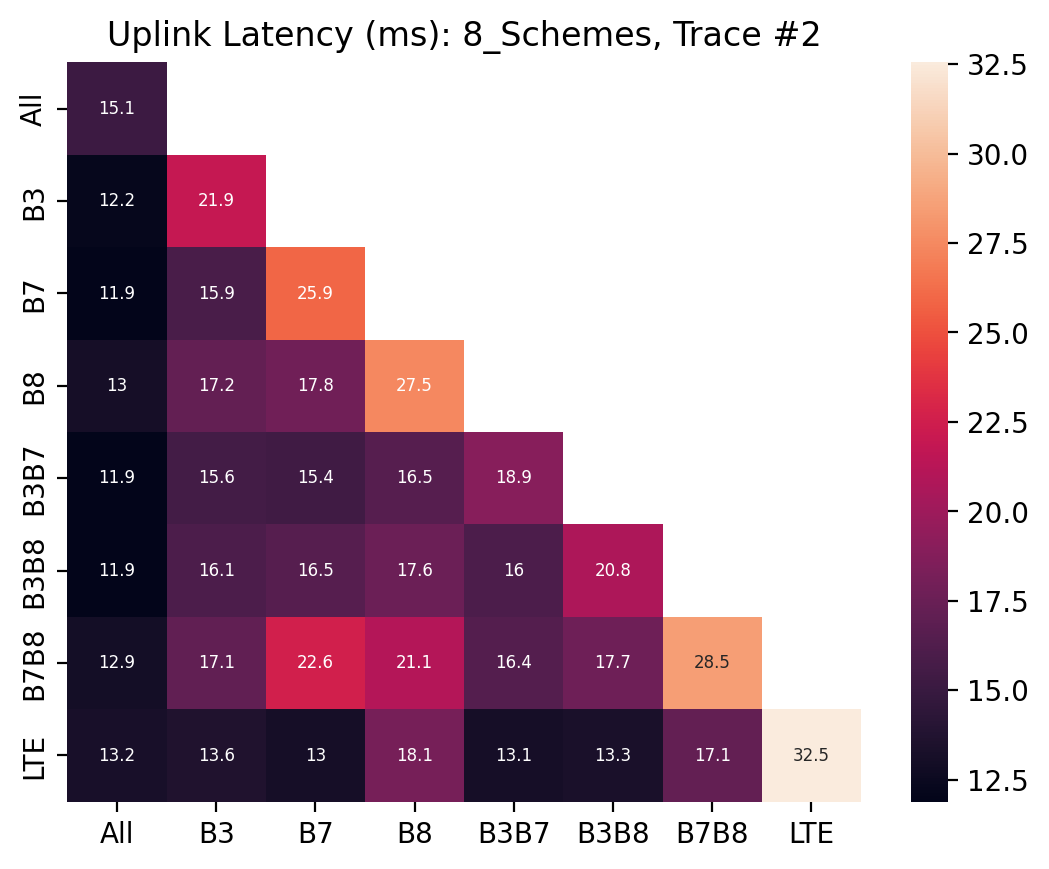

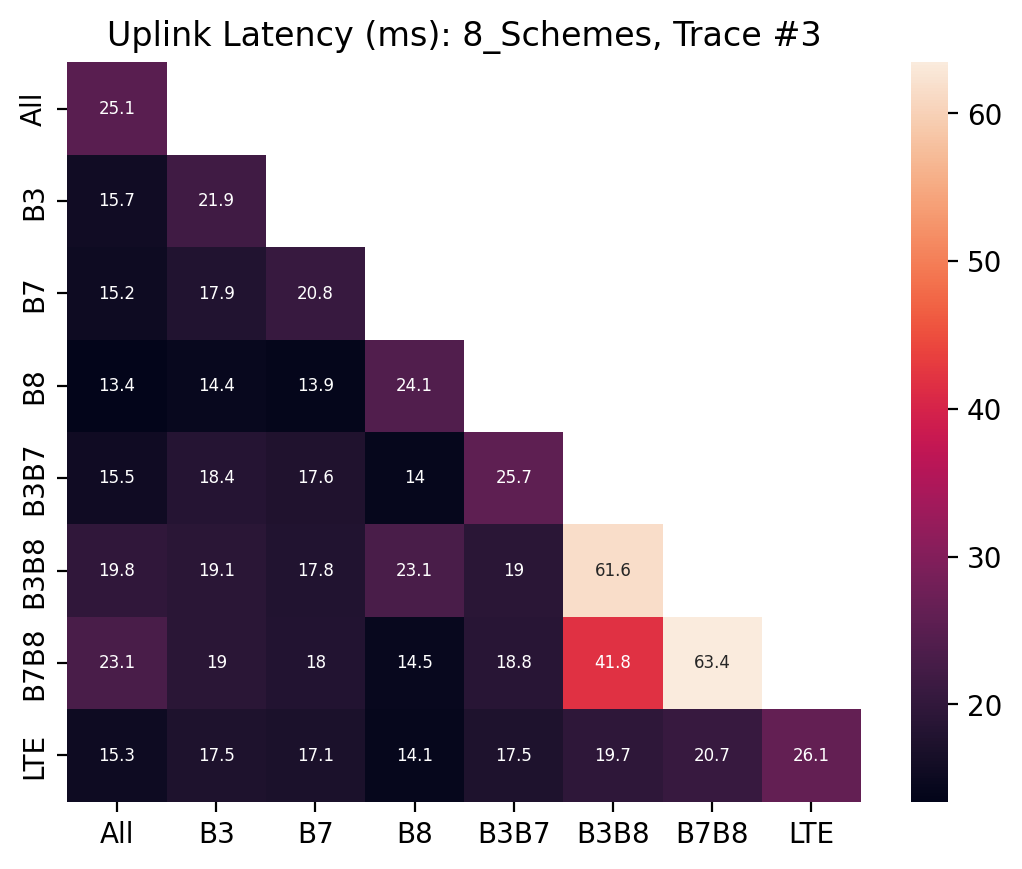

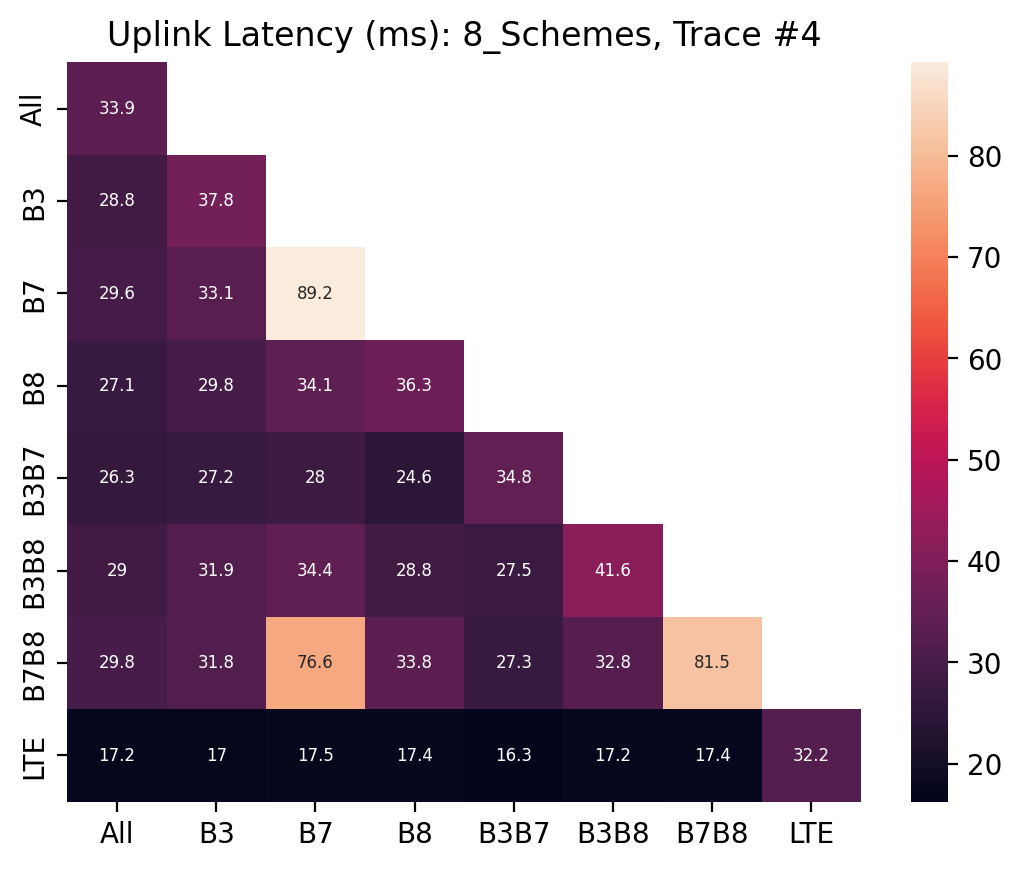

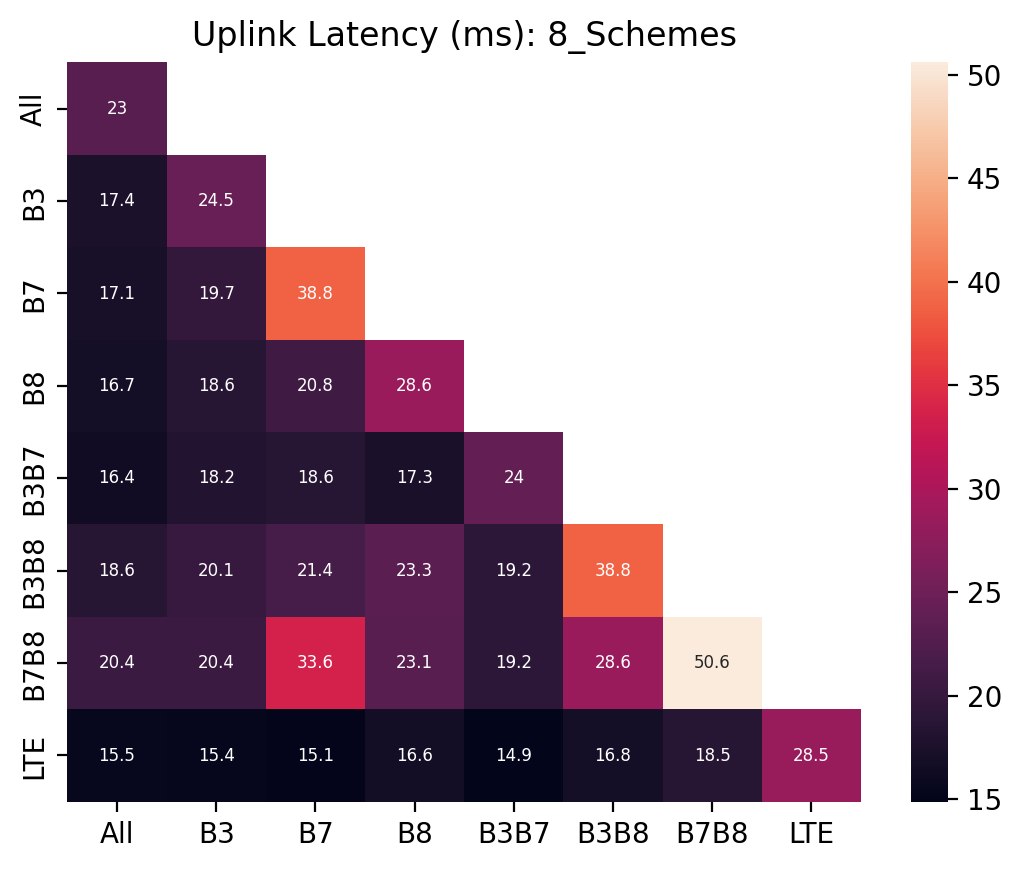

In [36]:
N = len(dfs_ul)
devices = _devices[0]

table = pd.DataFrame(columns=tags)
for i in range(N):
    row = []
    for x, tag in zip(xs, tags):
        if type(x) is not tuple:
            if not dfs_ul[i][x].empty:
                df = dfs_ul[i][x].copy()
                latency = df[~df.lost].latency.mean() * 1000
            else:
                latency = np.nan
        else:
            if not (dfs_ul[i][x[0]].empty or dfs_ul[i][x[1]].empty):
                df = pd.merge(dfs_ul[i][x[0]].copy(), dfs_ul[i][x[1]].copy(), on=['seq'], suffixes=('_m','_s')).copy()
                latency = df.loc[~(df.lost_m & df.lost_s), ['latency_m','latency_s']].min(axis=1).mean() * 1000
            else:
                latency = np.nan
        row.append(latency)
    table = pd.concat([table, pd.DataFrame(row, index=table.columns).T])
    ## draw heatmap for one trace
    mat = fill_out_matrix(schemes, mtags, pd.DataFrame(row, index=table.columns).T.mean().to_dict())
    ax = sns.heatmap(mat.T, annot=True, fmt='.3g', mask=mask(len(schemes)), annot_kws={"size": 6})
    ax.set_title(f'Uplink Latency (ms): {title}, Trace #{i+1}')
    plt.savefig(os.path.join(path, f'{title}_ULLat2_{i+1}.png'), bbox_inches='tight', dpi=300)
    plt.show()

mat = fill_out_matrix(schemes, mtags, table.mean().to_dict())
ax = sns.heatmap(mat.T, annot=True, fmt='.3g', mask=mask(len(schemes)), annot_kws={"size": 6})
ax.set_title(f'Uplink Latency (ms): {title}')
plt.savefig(os.path.join(path, f'{title}_ULLat2.png'), bbox_inches='tight', dpi=300)
plt.show()

## Downlink Latency (except for lost)

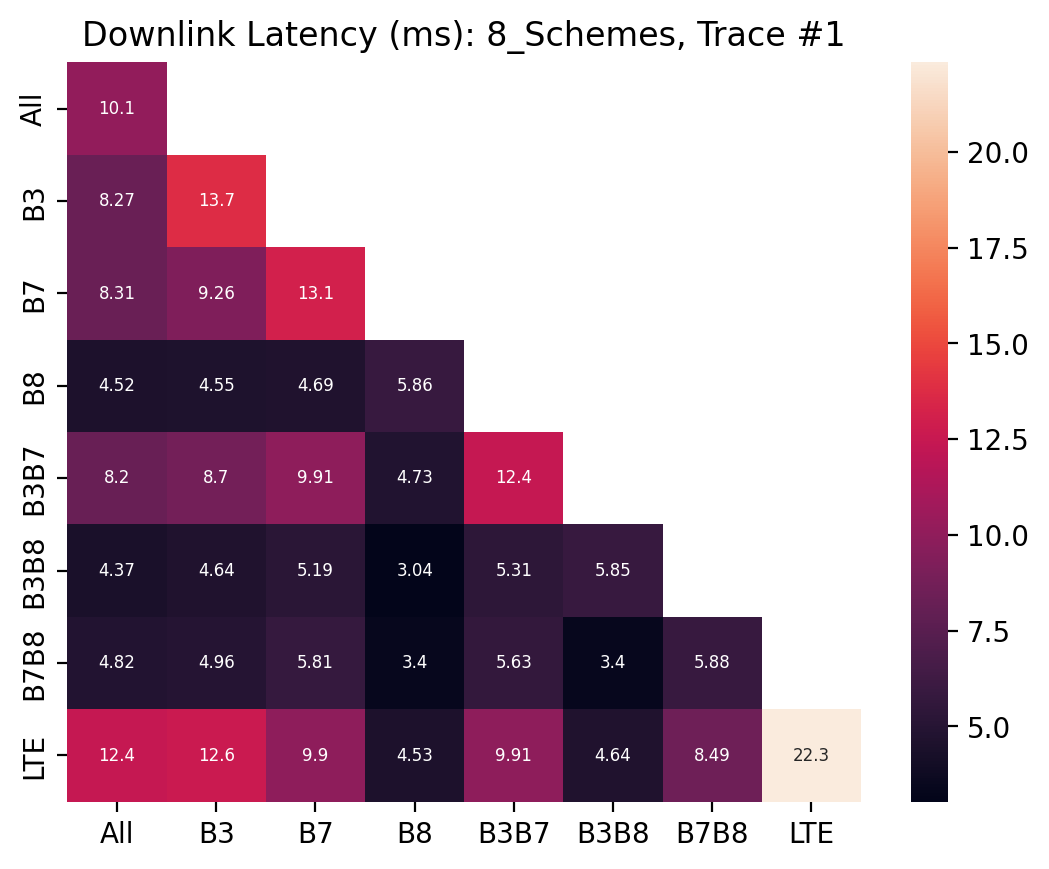

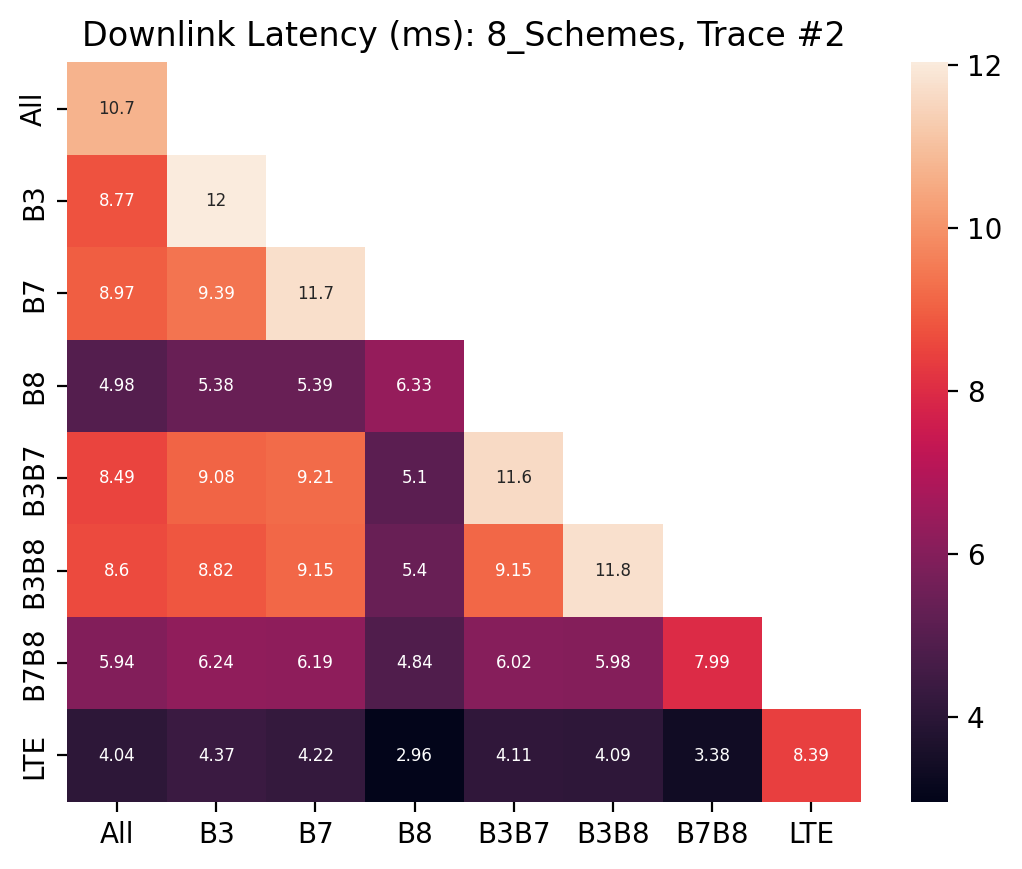

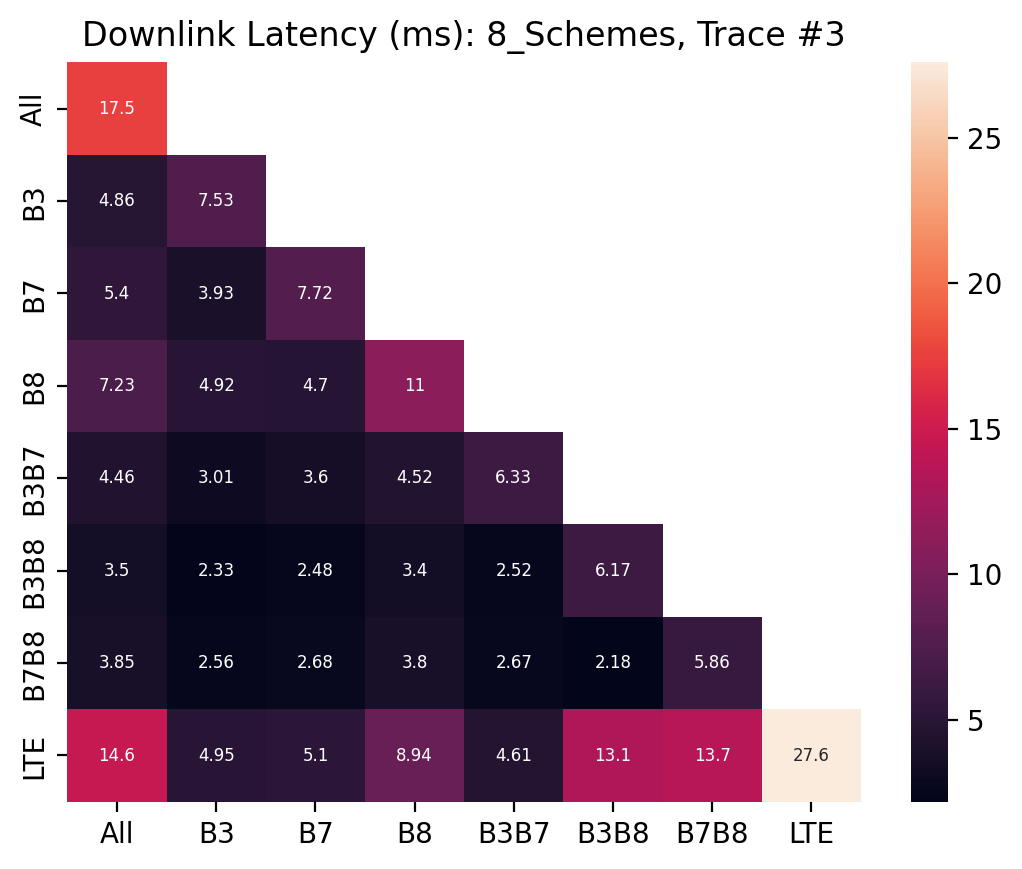

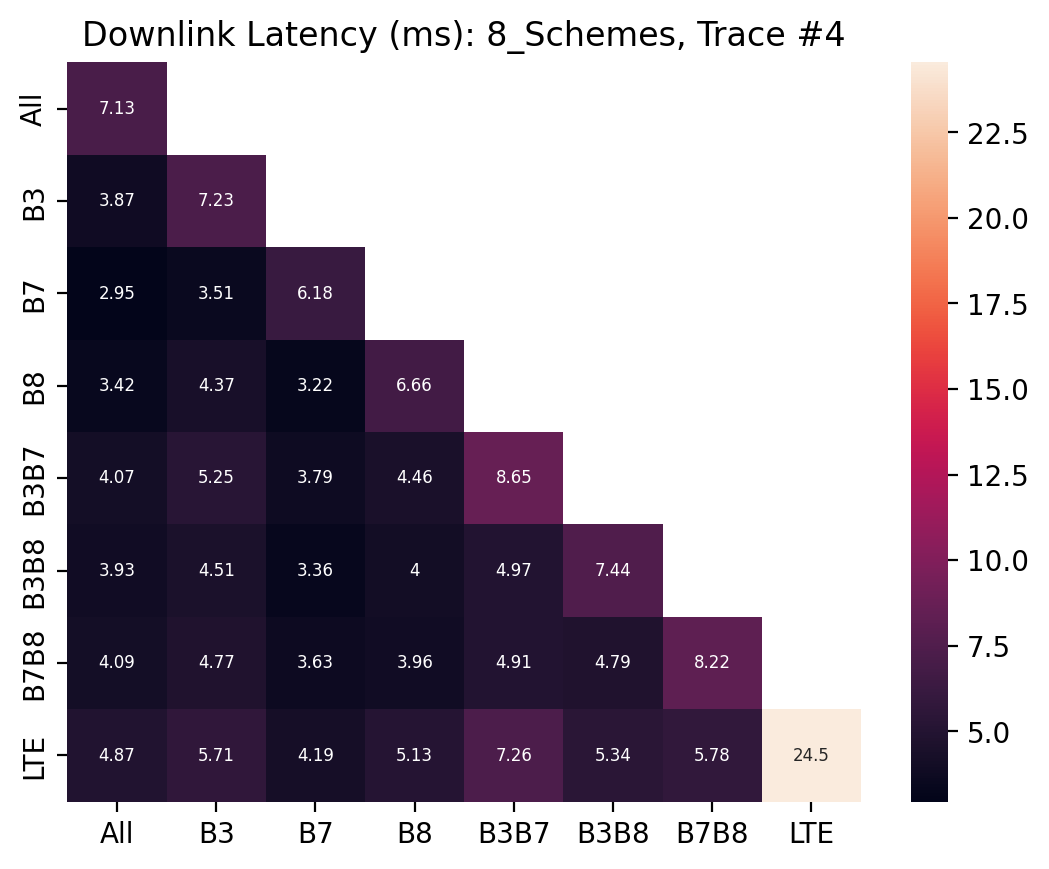

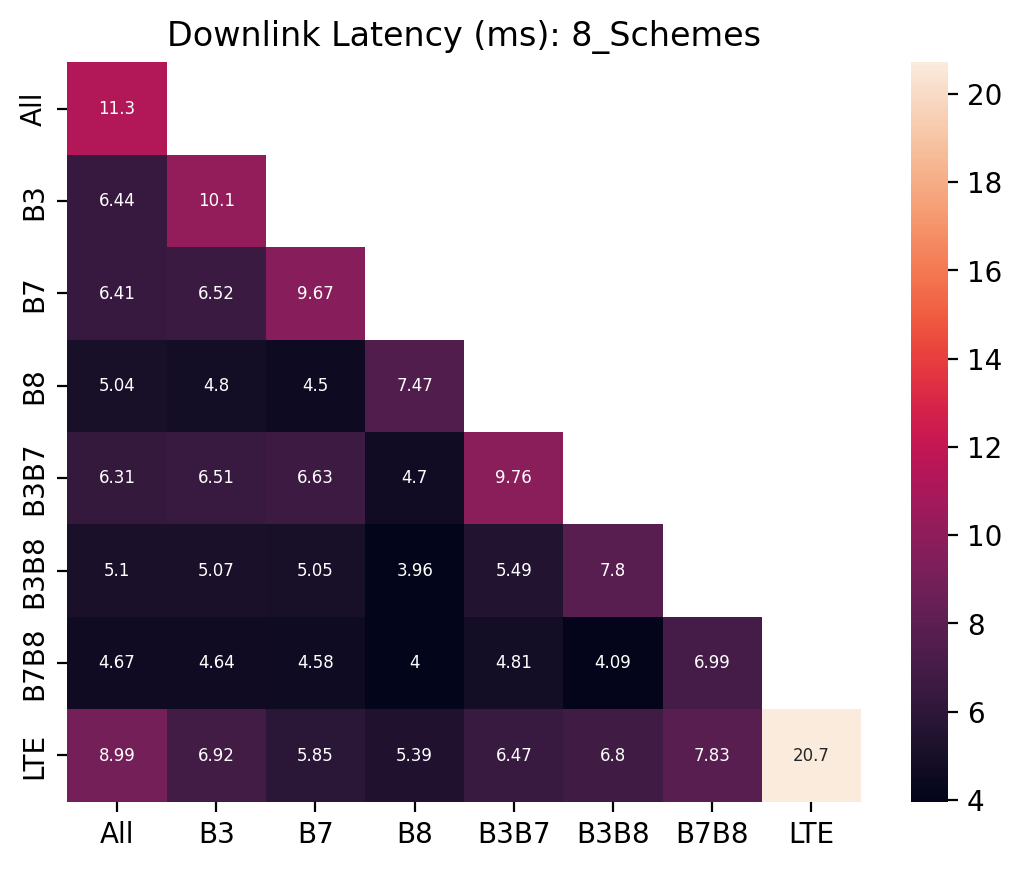

In [37]:
N = len(dfs_dl)
devices = _devices[0]

table = pd.DataFrame(columns=tags)
for i in range(N):
    row = []
    for x, tag in zip(xs, tags):
        if type(x) is not tuple:
            if not dfs_dl[i][x].empty:
                df = dfs_dl[i][x].copy()
                latency = df[~df.lost].latency.mean() * 1000
            else:
                latency = np.nan
        else:
            if not (dfs_dl[i][x[0]].empty or dfs_dl[i][x[1]].empty):
                df = pd.merge(dfs_dl[i][x[0]].copy(), dfs_dl[i][x[1]].copy(), on=['seq'], suffixes=('_m','_s')).copy()
                latency = df.loc[~(df.lost_m & df.lost_s), ['latency_m','latency_s']].min(axis=1).mean() * 1000
            else:
                latency = np.nan
        row.append(latency)
    table = pd.concat([table, pd.DataFrame(row, index=table.columns).T])
    ## draw heatmap for one trace
    mat = fill_out_matrix(schemes, mtags, pd.DataFrame(row, index=table.columns).T.mean().to_dict())
    ax = sns.heatmap(mat.T, annot=True, fmt='.3g', mask=mask(len(schemes)), annot_kws={"size": 6})
    ax.set_title(f'Downlink Latency (ms): {title}, Trace #{i+1}')
    plt.savefig(os.path.join(path, f'{title}_DLLat2_{i+1}.png'), bbox_inches='tight', dpi=300)
    plt.show()

mat = fill_out_matrix(schemes, mtags, table.mean().to_dict())
ax = sns.heatmap(mat.T, annot=True, fmt='.3g', mask=mask(len(schemes)), annot_kws={"size": 6})
ax.set_title(f'Downlink Latency (ms): {title}')
plt.savefig(os.path.join(path, f'{title}_DLLat2.png'), bbox_inches='tight', dpi=300)
plt.show()